In [1]:
%matplotlib inline
from astropy import units as u, constants, visualization
from astropy import constants as const
from PIL import Image
from astropy.io import fits
import numpy as np
import pylab as pl
import glob
pl.rcParams['image.origin'] = 'lower'
pl.matplotlib.style.use('dark_background')

## Dark Subtraction

In [2]:
jupiter_data = (np.mean([fits.getdata(x) for x in glob.glob('jupiter_5s00*.FIT')],
                      axis=0)
              - np.median([fits.getdata(x)
                         for x in glob.glob('dark_5s00*.FIT')],
                        axis=0)
             )
jupiter_lines = jupiter_data[365:442,:]

(370.0, 435.0)

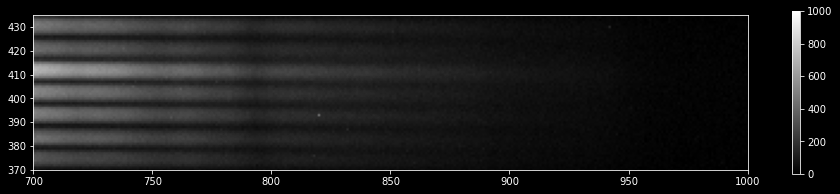

In [3]:
pl.figure(figsize = (16,3))
pl.imshow(jupiter_data, cmap='gray', vmax=0, vmin=1000)
pl.colorbar()
pl.xlim(700,1000)
pl.ylim(370,435)

In [4]:
dy = -5
dx = 900
slope = dy/dx
ystart = 370
yend = 440

(0.0, 900.0)

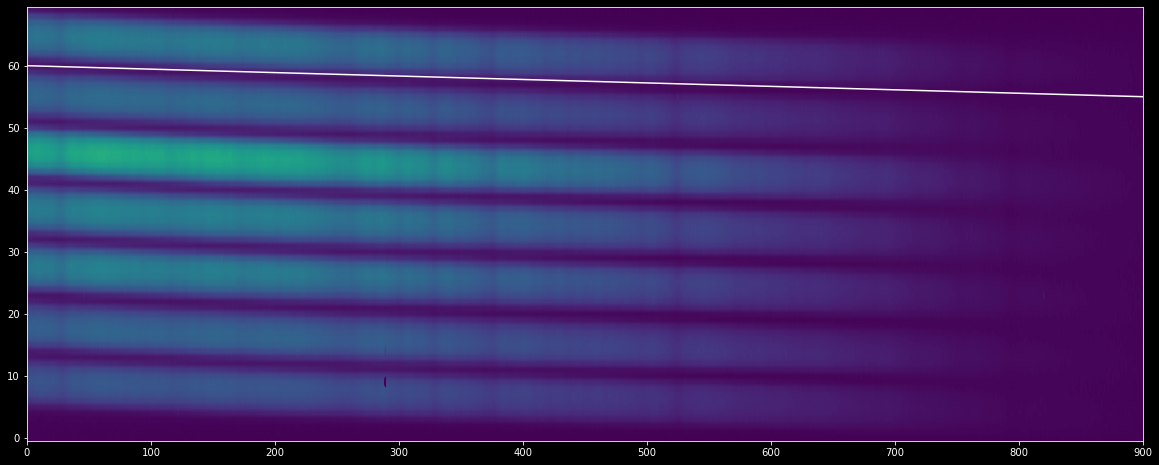

In [5]:
pl.figure(figsize = (20,10))
jupiter_array = np.array(jupiter_data)
jupiter_array = jupiter_array - np.median(jupiter_array)
pl.imshow(jupiter_array[ystart:yend,:], vmax=6000, vmin=0)
pl.plot([0,1000], 60 + np.array([0,1000]) * slope, color='w')
pl.gca().set_aspect(5)
pl.xlim(0,900)

(0.0, 1000.0)

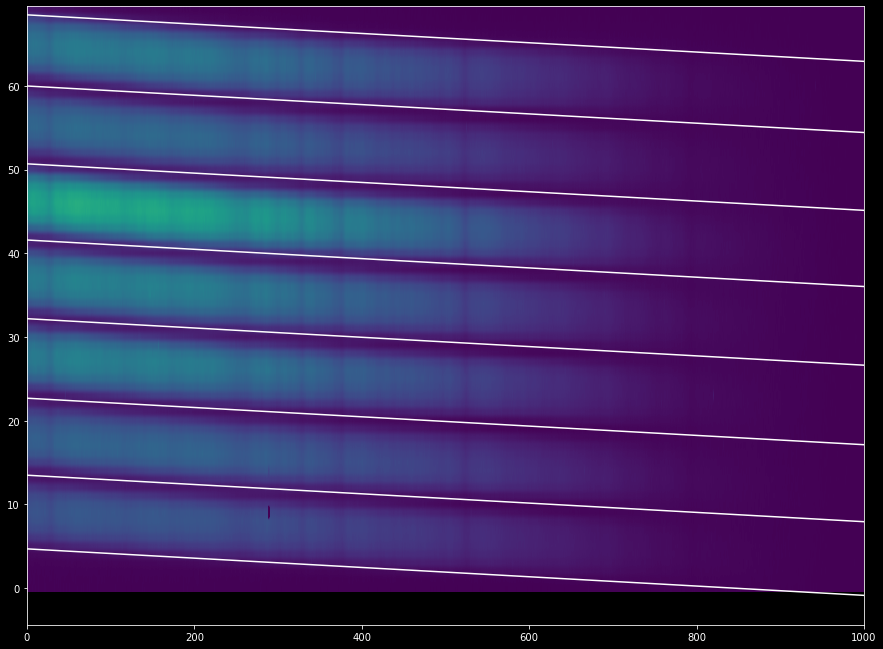

In [6]:
pl.figure(figsize = (15,20))
intertrace_cuts = np.array([ 4.7, 13.5, 22.7, 32.2, 41.6, 50.7, 60, 68.5])
jupiter_array = np.array(jupiter_data)
jupiter_array = jupiter_array - np.median(jupiter_array)
pl.imshow(jupiter_array[ystart:yend,:], vmax=6000, vmin=0)
pl.plot([0,1000], intertrace_cuts + np.array([0,1000])[:,None] * slope, color='w')
pl.gca().set_aspect(10)
pl.xlim(0,1000)

In [7]:
npixels_to_cut = 4 # very conservative - we'll see why below
xvals = np.arange(jupiter_array.shape[1])
trace_center = ystart+(intertrace_cuts[0] + intertrace_cuts[1])/2 + xvals * slope
cutout_trace = np.array([jupiter_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii]
                    for yval, ii in zip(trace_center, xvals)]).T
cutout_trace.shape

(8, 1530)

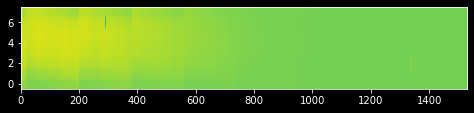

In [8]:
pl.figure(figsize = (8,2))
pl.imshow(cutout_trace)
pl.gca().set_aspect(35);

In [9]:
# to get the y-axis values corresponding to each part of our cutout trace, we do the same operation we did on the jupiter
yaxis_full = np.arange(jupiter_array.shape[0])
yaxis = np.array([yaxis_full[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut]
                    for yval, ii in zip(trace_center, xvals)]).T

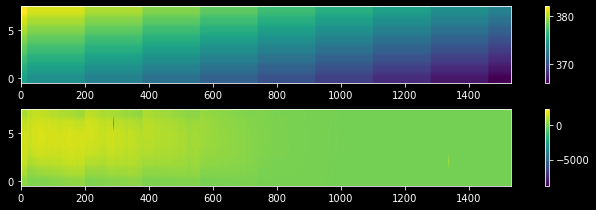

In [10]:
pl.figure(figsize=(10,3))
im = pl.subplot(2,1,1).imshow(yaxis)
pl.colorbar(mappable=im)
pl.gca().set_aspect(30);
im = pl.subplot(2,1,2).imshow(cutout_trace)
pl.colorbar(mappable=im)
pl.gca().set_aspect(30);
pl.tight_layout();

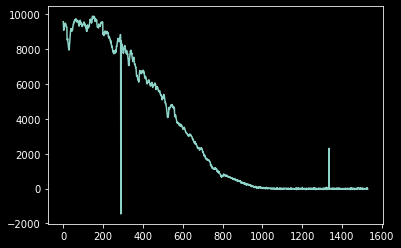

In [11]:
pl.plot(cutout_trace.sum(axis=0))

In [12]:
# moment 1 is the data-weighted average of the Y-axis coordinates
xend = 800
weighted_yaxis_values = np.average(yaxis[:,:xend], axis=0,
                                   weights=cutout_trace[:,:xend])

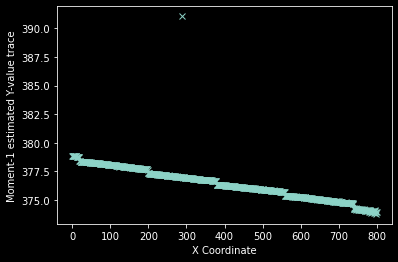

In [13]:
_=pl.plot(xvals[:xend], weighted_yaxis_values, 'x')
_=pl.xlabel("X Coordinate")
_=pl.ylabel("Moment-1 estimated Y-value trace")

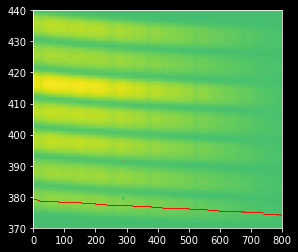

In [14]:
# we need to use the 'extent' keyword to have the axes correctly labeled
_=pl.imshow(jupiter_array[ystart:yend, :xend],
            extent=[0,xend,ystart,yend],
           )
_=pl.gca().set_aspect(10) # we stretch the jupiter out by 10x in the y-direction
_=pl.plot(xvals[:xend], weighted_yaxis_values[:xend], 'r,', alpha=0.5)
_=pl.axis((0,xend,ystart,yend))

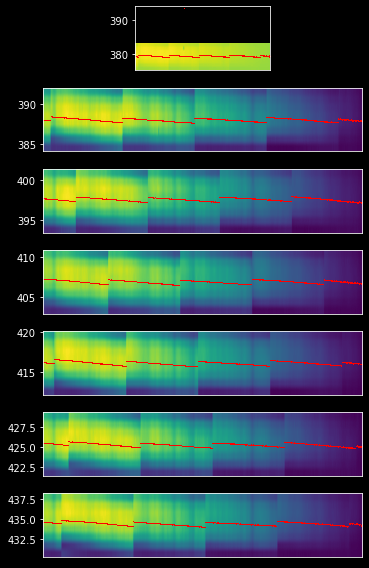

In [15]:
pl.figure(figsize=(10,8))
traces = {}
for trace_index in range(len(intertrace_cuts)-1):
    yoffset = ystart + (intertrace_cuts[trace_index] + intertrace_cuts[trace_index+1])/2
    trace_center = yoffset + slope * xvals

    cutout_trace = np.array([jupiter_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii]
                        for yval, ii in zip(trace_center, xvals)]).T
    yaxis = np.array([yaxis_full[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut]
                     for yval, ii in zip(trace_center, xvals)]).T
    weighted_yaxis_values = np.average(yaxis[:,:xend], axis=0,
                                   weights=cutout_trace[:,:xend])
    
    # it takes a little mental gymnastics to get to this, but: to show the trace properly on our cutout,
    # we need to calculate the local version
    local_weighted_yaxis_values = np.average(np.arange(npixels_to_cut*2)[:,None] * np.ones(xend)[None,:],
                                             axis=0, weights=cutout_trace[:,:xend])
    
    traces[trace_index] = weighted_yaxis_values
    ax = pl.subplot(7, 1, trace_index+1)
    ax.imshow(cutout_trace[:,:xend], extent=[0, xend, yoffset-npixels_to_cut, yoffset + npixels_to_cut])
    ax.plot(xvals[:xend], yoffset - npixels_to_cut + local_weighted_yaxis_values[:xend], 'r,')
    ax.set_aspect(20)
    ax.set_xticks([])
pl.tight_layout()

(0.0, 800.0, 370.0, 440.0)

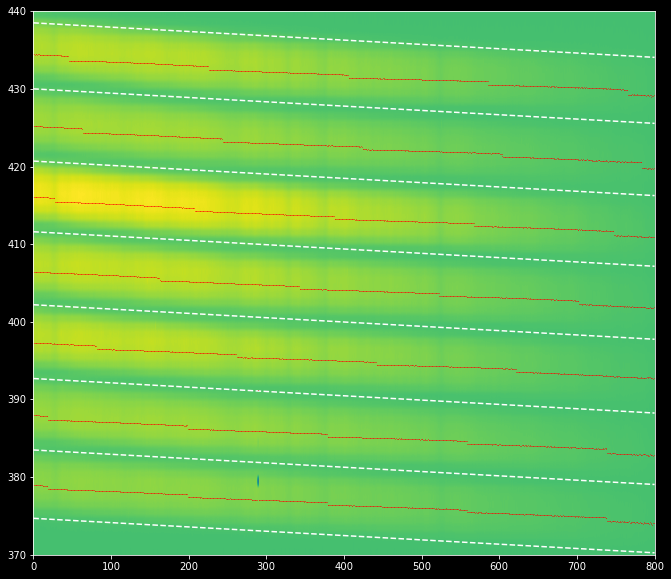

In [16]:
# then we can plot the "global" version here
pl.figure(figsize=(15,10))
pl.imshow(jupiter_array[ystart:yend, :xend],
          extent=[0,xend,ystart,yend],
         )
pl.plot([0,xend], ystart + intertrace_cuts + np.array([0,xend])[:,None] * slope, color='w', linestyle='--')
pl.gca().set_aspect(10)
for trace in traces.values():
    pl.plot(xvals[:xend], trace[:xend], 'r,', alpha=0.5)
pl.axis((0,xend,ystart,yend))

In [17]:
from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.fitting import LinearLSQFitter

In [18]:
# We fit a 2rd-order polynomial
polymodel = Polynomial1D(degree=2)
linfitter = LinearLSQFitter()
fitted_polymodels = {index: linfitter(polymodel, xvals[:xend], weighted_yaxis_values[:xend])
                     for index, weighted_yaxis_values in traces.items()}
fitted_polymodels

{0: <Polynomial1D(2, c0=378.58703031, c1=-0.00512683, c2=-0.00000068)>,
 1: <Polynomial1D(2, c0=387.50896649, c1=-0.00573564, c2=-0.00000001)>,
 2: <Polynomial1D(2, c0=397.12449516, c1=-0.00614063, c2=0.00000068)>,
 3: <Polynomial1D(2, c0=406.34954889, c1=-0.00575521, c2=0.00000006)>,
 4: <Polynomial1D(2, c0=415.69815607, c1=-0.00638652, c2=0.00000076)>,
 5: <Polynomial1D(2, c0=424.92274991, c1=-0.00664743, c2=0.00000096)>,
 6: <Polynomial1D(2, c0=434.11619179, c1=-0.00680814, c2=0.0000012)>}

(0.0, 800.0, 370.0, 440.0)

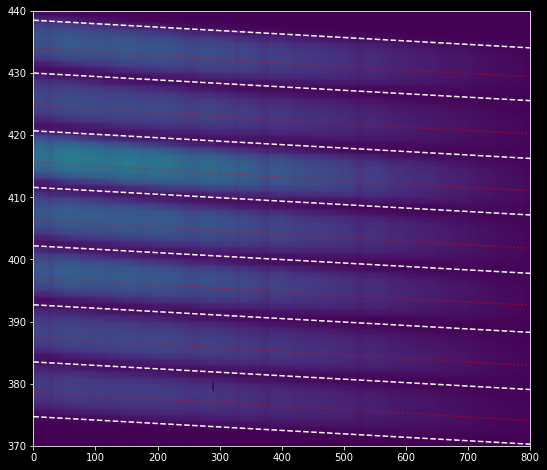

In [19]:
pl.figure(figsize=(10,8))
pl.imshow(jupiter_array[ystart:yend, :xend],
          extent=[0,xend,ystart,yend],
          vmin=0, vmax=9000,
         )
pl.plot([0,xend], ystart + intertrace_cuts + np.array([0,xend])[:,None] * slope, color='w', linestyle='--')
pl.gca().set_aspect(10)
for tracefit in fitted_polymodels.values():
    pl.plot(xvals[:xend], tracefit(xvals[:xend]), 'r:', alpha=0.5)
pl.axis((0,xend,ystart,yend))

In [20]:
from astropy.modeling.models import Gaussian1D
from astropy.modeling.fitting import LevMarLSQFitter
lmfitter = LevMarLSQFitter()
guess = Gaussian1D(amplitude=160, mean=0, stddev=5)

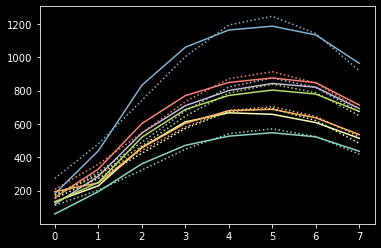

In [21]:
npixels_to_cut_trace = 4

for trace_index, polymodel_trace in fitted_polymodels.items():
    trace_center = polymodel_trace(xvals)

    cutout_trace = np.array([jupiter_array[int(yval)-npixels_to_cut_trace:int(yval)+npixels_to_cut_trace, ii]
                        for yval, ii in zip(trace_center, xvals)]).T

    trace_profile = cutout_trace.mean(axis=1)
    trace_profile_xaxis = np.arange(len(trace_profile))
    fitted_trace_profile = lmfitter(model=guess, x=trace_profile_xaxis, y=trace_profile)
    model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
    
    line, = pl.plot(trace_profile, label=trace_index)
    pl.plot(trace_profile_xaxis, model_trace_profile, color=line.get_color(), linestyle=':')

In [22]:
jupiter_spectra = {}
for trace_index, polymodel_trace in fitted_polymodels.items():
    trace_center = polymodel_trace(xvals)

    cutout_trace = np.array([jupiter_array[int(yval)-npixels_to_cut_trace:int(yval)+npixels_to_cut_trace, ii]
                        for yval, ii in zip(trace_center, xvals)]).T

    trace_profile = cutout_trace.mean(axis=1)
    trace_profile_xaxis = np.arange(len(trace_profile))
    fitted_trace_profile = lmfitter(model=guess, x=trace_profile_xaxis, y=trace_profile)
    model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
    
    trace_avg_spectrum = np.array([np.average(
            jupiter_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
            weights=trace_profile)
                               for yval, ii in zip(trace_center, xvals)])
    jupiter_spectra[trace_index] = trace_avg_spectrum

(0.0, 800.0)

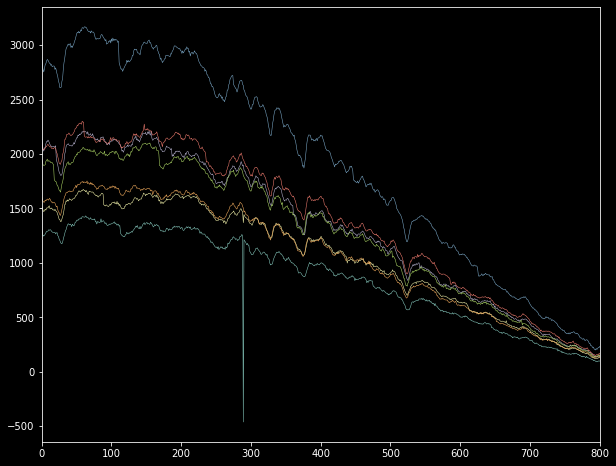

In [23]:
pl.figure(figsize=(10,8))
for index in jupiter_spectra:
    pl.plot(jupiter_spectra[index], linewidth=0.5)
pl.xlim(0,800)

# Fitting Trace and Extracting Spectra

## Flats

In [24]:
flats_data = (np.mean([fits.getdata(x) for x in glob.glob('flat_30s00*.FIT')],
                      axis=0)
              - np.median([fits.getdata(x)
                         for x in glob.glob('dark_30s00*.FIT')],
                        axis=0))
flats_array = np.array(flats_data)
flats_array = flats_array - np.median(flats_array)

(350.0, 450.0)

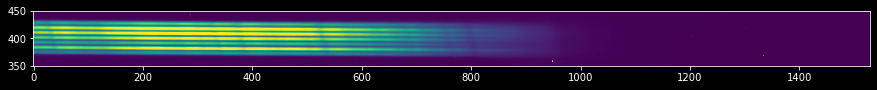

In [25]:
pl.figure(figsize=(15,8))
pl.imshow(flats_array, vmin=0, vmax=4500)
pl.ylim(350,450)

(0.0, 800.0, 366.0, 436.0)

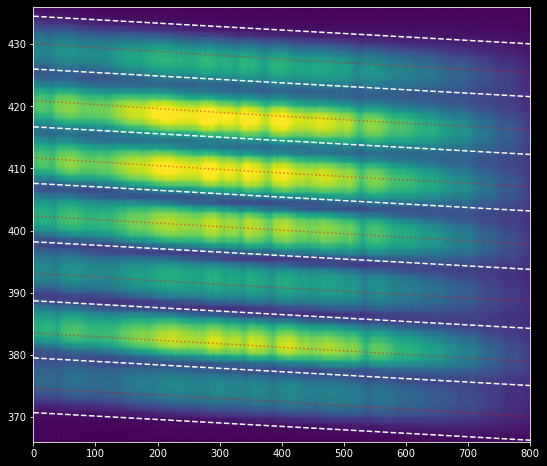

In [26]:
pl.figure(figsize=(10,8))
offset = -4
pl.imshow(flats_array[ystart+offset:yend+offset, :xend],
          extent=[0,xend,ystart+offset,yend+offset],
          vmin=0, vmax=5500,
         )
pl.plot([0,xend], ystart+offset + intertrace_cuts + np.array([0,xend])[:,None] * slope, color='w', linestyle='--')
pl.gca().set_aspect(10)
for tracefit in fitted_polymodels.values():
    pl.plot(xvals[:xend], tracefit(xvals[:xend])+offset, 'r:', alpha=0.5)
pl.axis((0,xend,ystart+offset,yend+offset))

In [27]:
flats_spectra = {}
for trace_index, polymodel_trace in fitted_polymodels.items():
    trace_center = polymodel_trace(xvals) + offset

    model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
    
    trace_avg_spectrum = np.array([np.average(
            flats_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
            weights=model_trace_profile)
                               for yval, ii in zip(trace_center, xvals)])

    flats_spectra[trace_index] = trace_avg_spectrum

(0.0, 800.0)

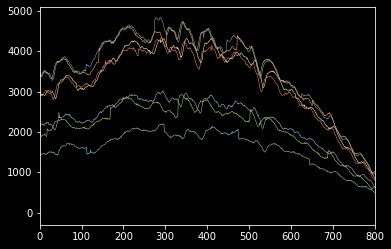

In [28]:
for index in flats_spectra:
    pl.plot(flats_spectra[index], linewidth=0.5)
pl.xlim(0,800)

## Helium

### Beginning of the night

In [29]:
helium_data1 = (fits.getdata('helium_20s.FIT')) - (fits.getdata('dark_20s001.FIT'))
helium_array1 = helium_data1

(350.0, 450.0)

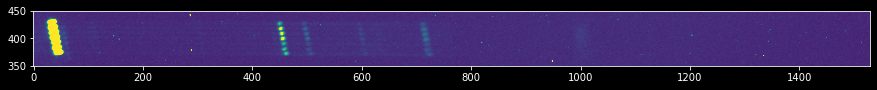

In [30]:
pl.figure(figsize=(15,8))
pl.imshow(helium_array1, vmax=800)
pl.ylim(350,450)

(0.0, 800.0, 367.0, 437.0)

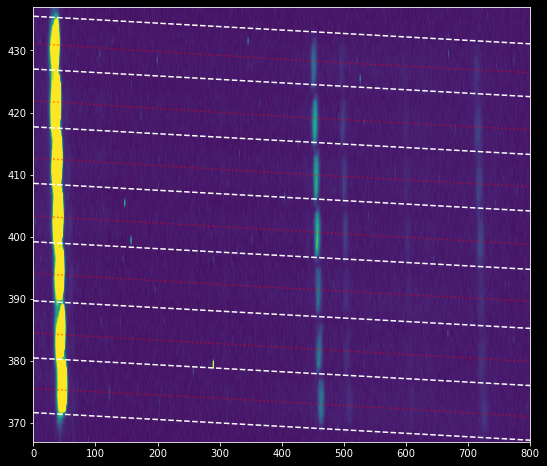

In [31]:
pl.figure(figsize=(10,8))
offset = -3
pl.imshow(helium_array1[ystart+offset:yend+offset, :xend],
          extent=[0,xend,ystart+offset,yend+offset],
          vmin=0, vmax=1500,
         )
pl.plot([0,xend], ystart+offset + intertrace_cuts + np.array([0,xend])[:,None] * slope, color='w', linestyle='--')
pl.gca().set_aspect(10)
for tracefit in fitted_polymodels.values():
    pl.plot(xvals[:xend], tracefit(xvals[:xend])+offset, 'r:', alpha=0.5)
pl.axis((0,xend,ystart+offset,yend+offset))

In [32]:
helium_spectra1 = {}
for trace_index, polymodel_trace in fitted_polymodels.items():
    trace_center = polymodel_trace(xvals) + offset

    model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
    
    trace_avg_spectrum = np.array([np.average(
            helium_array1[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
            weights=model_trace_profile)
                               for yval, ii in zip(trace_center, xvals)])

    helium_spectra1[trace_index] = trace_avg_spectrum

Text(0.5, 0, 'Wavelength [nm]')

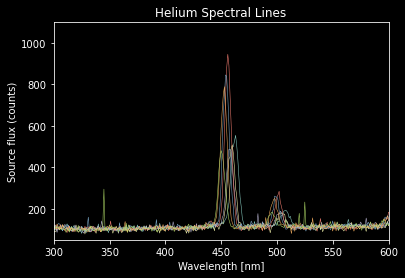

In [33]:
for index in helium_spectra1:
    pl.plot(helium_spectra1[index], linewidth=0.5)
pl.xlim(300,600)
pl.ylim(50,1100)
pl.title("Helium Spectral Lines")
pl.ylabel("Source flux (counts)")
pl.xlabel("Wavelength [nm]")

### End of the night

In [34]:
# There was no signal in the image :(

## Neon

### Beginning of the Night

In [35]:
neon_data1 = (fits.getdata('neon_20s.FIT')) - (fits.getdata('dark_20s001.FIT'))
neon_array1 = neon_data1

(350.0, 450.0)

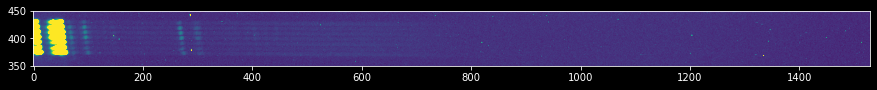

In [36]:
pl.figure(figsize=(15,8))
pl.imshow(neon_array1, vmax=800)
pl.ylim(350,450)

(0.0, 800.0, 367.0, 437.0)

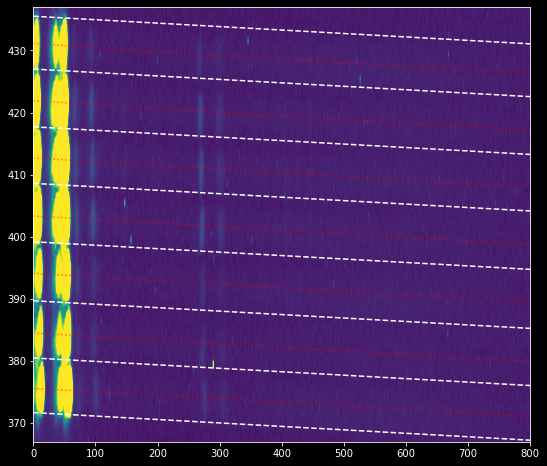

In [37]:
pl.figure(figsize=(10,8))
offset = -3
pl.imshow(neon_array1[ystart+offset:yend+offset, :xend],
          extent=[0,xend,ystart+offset,yend+offset],
          vmin=0, vmax=1500,
         )
pl.plot([0,xend], ystart+offset + intertrace_cuts + np.array([0,xend])[:,None] * slope, color='w', linestyle='--')
pl.gca().set_aspect(10)
for tracefit in fitted_polymodels.values():
    pl.plot(xvals[:xend], tracefit(xvals[:xend])+offset, 'r:', alpha=0.5)
pl.axis((0,xend,ystart+offset,yend+offset))

In [38]:
neon_spectra1 = {}
trace_avg_spectrum = None
for trace_index, polymodel_trace in fitted_polymodels.items():
    trace_center = polymodel_trace(xvals) + offset

    model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
    
    trace_avg_spectrum = np.array([np.average(
            neon_array1[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
            weights=model_trace_profile)
                               for yval, ii in zip(trace_center, xvals)])

    neon_spectra1[trace_index] = trace_avg_spectrum

Text(0.5, 0, 'Wavelength [nm]')

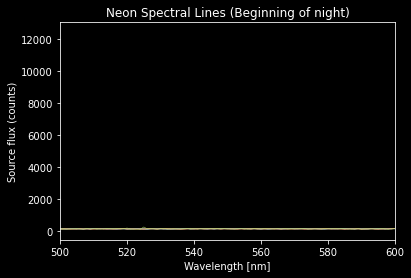

In [39]:
for index in neon_spectra1:
    pl.plot(neon_spectra1[index], linewidth=0.5)
pl.xlim(500,600)
# pl.ylim(0,100)
pl.title("Neon Spectral Lines (Beginning of night)")
pl.ylabel("Source flux (counts)")
pl.xlabel("Wavelength [nm]")

### End of the night

In [40]:
neon_data2 = np.mean([fits.getdata(x) for x in glob.glob('neon_10s_end_300*.FIT')],
                      axis=0)
neon_array2 = np.array(neon_data2)
neon_array2 = neon_array2 - np.median(neon_array2)

(350.0, 450.0)

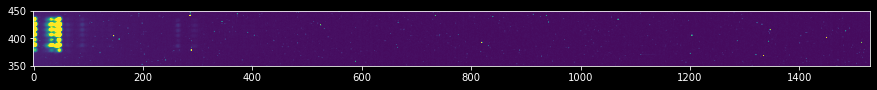

In [41]:
pl.figure(figsize=(15,8))
pl.imshow(neon_array2, vmax=1000)
pl.ylim(350,450)

(0.0, 800.0, 371.0, 441.0)

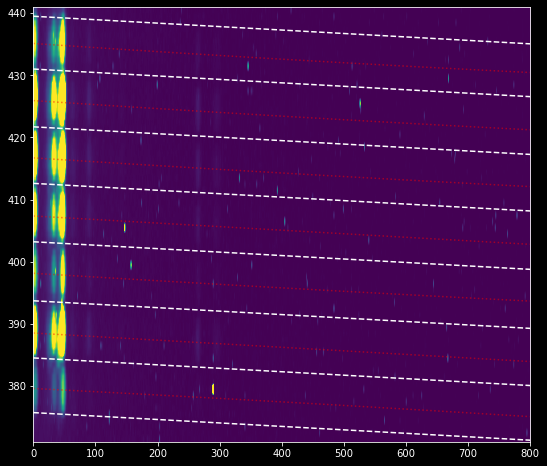

In [42]:
pl.figure(figsize=(10,8))
offset = 1
pl.imshow(neon_array2[ystart+offset:yend+offset, :xend],
          extent=[0,xend,ystart+offset,yend+offset],
          vmin=0, vmax=1500,
         )
pl.plot([0,xend], ystart+offset + intertrace_cuts + np.array([0,xend])[:,None] * slope, color='w', linestyle='--')
pl.gca().set_aspect(10)
for tracefit in fitted_polymodels.values():
    pl.plot(xvals[:xend], tracefit(xvals[:xend])+offset, 'r:', alpha=0.5)
pl.axis((0,xend,ystart+offset,yend+offset))

In [43]:
neon_spectra2 = {}
for trace_index, polymodel_trace in fitted_polymodels.items():
    trace_center = polymodel_trace(xvals) + offset

    model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
    
    trace_avg_spectrum = np.array([np.average(
            neon_array2[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
            weights=model_trace_profile)
                               for yval, ii in zip(trace_center, xvals)])

    neon_spectra2[trace_index] = trace_avg_spectrum

Text(0.5, 0, 'Wavelength [nm]')

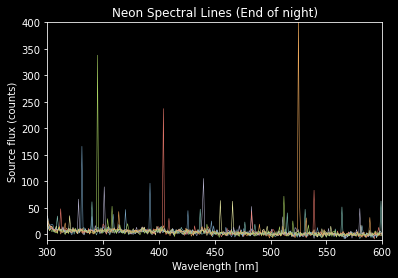

In [44]:
for index in neon_spectra2:
    pl.plot(neon_spectra2[index], linewidth=0.5)
pl.xlim(300,600)
pl.ylim(-10,400)
pl.title("Neon Spectral Lines (End of night)")
pl.ylabel("Source flux (counts)")
pl.xlabel("Wavelength [nm]")

## Altair

In [45]:
altair_data = (np.mean([fits.getdata(x) for x in glob.glob('altair_5s_300*.FIT')],
                      axis=0)
              - np.median([fits.getdata(x)
                         for x in glob.glob('dark_5s00*.FIT')],
                        axis=0))
altair_array = np.array(altair_data)
altair_array = altair_array - np.median(altair_array)

(350.0, 450.0)

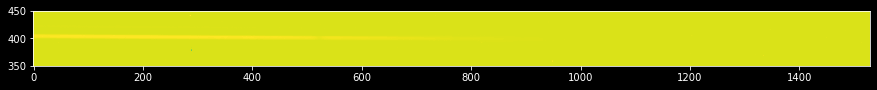

In [46]:
pl.figure(figsize=(15,8))
pl.imshow(altair_array, vmax=800)
pl.ylim(350,450)

(0.0, 800.0, 368.0, 438.0)

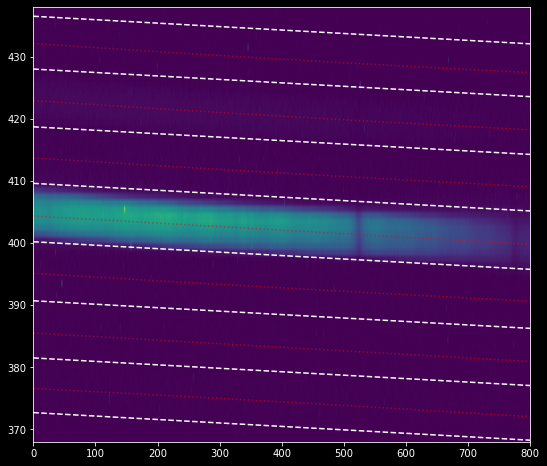

In [47]:
pl.figure(figsize=(10,8))
offset = -2
pl.imshow(altair_array[ystart+offset:yend+offset, :xend],
          extent=[0,xend,ystart+offset,yend+offset],
          vmin=0, vmax=1500,
         )
pl.plot([0,xend], ystart+offset + intertrace_cuts + np.array([0,xend])[:,None] * slope, color='w', linestyle='--')
pl.gca().set_aspect(10)
for tracefit in fitted_polymodels.values():
    pl.plot(xvals[:xend], tracefit(xvals[:xend])+offset, 'r:', alpha=0.5)
pl.axis((0,xend,ystart+offset,yend+offset))

In [48]:
altair_spectra = {}
for trace_index, polymodel_trace in fitted_polymodels.items():
    trace_center = polymodel_trace(xvals) + offset

    model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
    
    trace_avg_spectrum = np.array([np.average(
            altair_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
            weights=model_trace_profile)
                               for yval, ii in zip(trace_center, xvals)])

    altair_spectra[trace_index] = trace_avg_spectrum

(0.0, 1000.0)

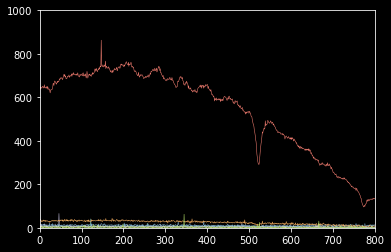

In [49]:
for index in altair_spectra:
    pl.plot(altair_spectra[index], linewidth=0.5)
pl.xlim(0,800)
pl.ylim(0,1000)

## Vega

In [50]:
vega_data = (np.mean([fits.getdata(x) for x in glob.glob('vega_5s00*.FIT')],
                      axis=0)
              - np.median([fits.getdata(x)
                         for x in glob.glob('dark_5s00*.FIT')],
                        axis=0))
vega_array = np.array(vega_data)
vega_array = vega_array - np.median(vega_array)

(350.0, 450.0)

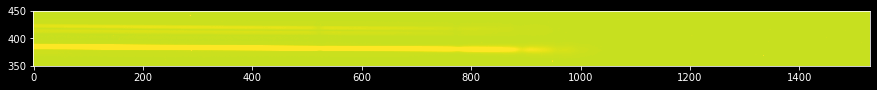

In [51]:
pl.figure(figsize=(15,8))
pl.imshow(vega_array, vmax=1000)
pl.ylim(350,450)

(0.0, 800.0, 368.0, 438.0)

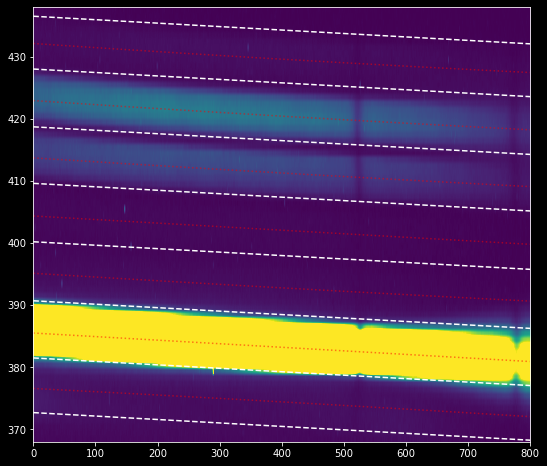

In [52]:
pl.figure(figsize=(10,8))
offset = -2
pl.imshow(vega_array[ystart+offset:yend+offset, :xend],
          extent=[0,xend,ystart+offset,yend+offset],
          vmin=0, vmax=1500,
         )
pl.plot([0,xend], ystart+offset + intertrace_cuts + np.array([0,xend])[:,None] * slope, color='w', linestyle='--')
pl.gca().set_aspect(10)
for tracefit in fitted_polymodels.values():
    pl.plot(xvals[:xend], tracefit(xvals[:xend])+offset, 'r:', alpha=0.5)
pl.axis((0,xend,ystart+offset,yend+offset))

In [53]:
vega_spectra = {}
for trace_index, polymodel_trace in fitted_polymodels.items():
    trace_center = polymodel_trace(xvals) + offset

    model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
    
    trace_avg_spectrum = np.array([np.average(
            vega_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
            weights=model_trace_profile)
                               for yval, ii in zip(trace_center, xvals)])

    vega_spectra[trace_index] = trace_avg_spectrum

(0.0, 500.0)

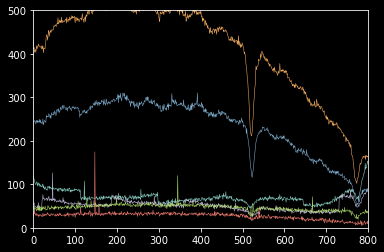

In [54]:
for index in vega_spectra:
    pl.plot(vega_spectra[index], linewidth=0.5)
pl.xlim(0,800)
pl.ylim(0,500)

## 31 Cygni

In [55]:
cyg31_data = (np.mean([fits.getdata(x) for x in glob.glob('31cyg_10s_300*.FIT')],
                      axis=0)
              - np.median([fits.getdata(x)
                         for x in glob.glob('dark_10s00*.FIT')],
                        axis=0))
cyg31_array = np.array(cyg31_data)
cyg31_array = cyg31_array - np.median(cyg31_array)

(350.0, 450.0)

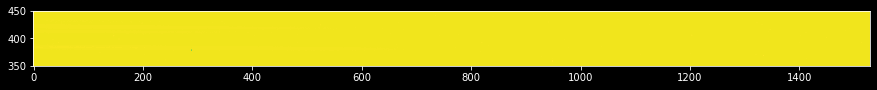

In [56]:
pl.figure(figsize=(15,8))
pl.imshow(cyg31_array, vmax=500)
pl.ylim(350,450)

(0.0, 800.0, 367.0, 437.0)

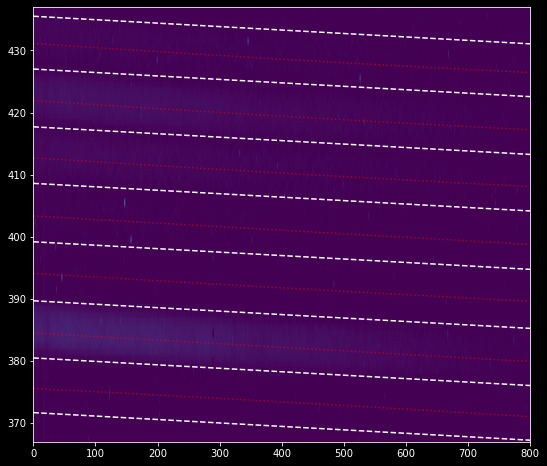

In [57]:
pl.figure(figsize=(10,8))
offset = -3
pl.imshow(cyg31_array[ystart+offset:yend+offset, :xend],
          extent=[0,xend,ystart+offset,yend+offset],
          vmin=0, vmax=1500,
         )
pl.plot([0,xend], ystart+offset + intertrace_cuts + np.array([0,xend])[:,None] * slope, color='w', linestyle='--')
pl.gca().set_aspect(10)
for tracefit in fitted_polymodels.values():
    pl.plot(xvals[:xend], tracefit(xvals[:xend])+offset, 'r:', alpha=0.5)
pl.axis((0,xend,ystart+offset,yend+offset))

In [58]:
cyg31_spectra = {}
for trace_index, polymodel_trace in fitted_polymodels.items():
    trace_center = polymodel_trace(xvals) + offset

    model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
    
    trace_avg_spectrum = np.array([np.average(
            cyg31_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
            weights=model_trace_profile)
                               for yval, ii in zip(trace_center, xvals)])

    cyg31_spectra[trace_index] = trace_avg_spectrum

(-10.0, 120.0)

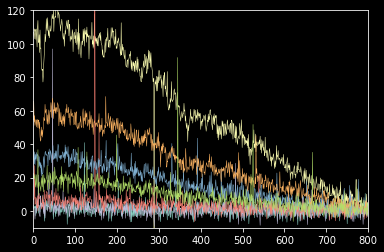

In [59]:
for index in cyg31_spectra:
    pl.plot(cyg31_spectra[index], linewidth=0.5)
pl.xlim(0,800)
pl.ylim(-10,120)

## Jupiter Moon

In [60]:
jupitermoon_data = (np.mean([fits.getdata(x) for x in glob.glob('jupiter_moon_20s00*.FIT')],
                      axis=0) - np.median([fits.getdata(x) for x in glob.glob('dark_5s00*.FIT')], axis=0))
jupitermoon_array = np.array(jupitermoon_data)
jupitermoon_array = jupitermoon_array - np.median(jupitermoon_array)

(350.0, 450.0)

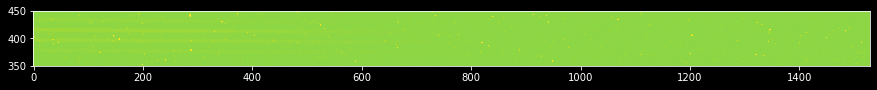

In [61]:
pl.figure(figsize=(15,8))
pl.imshow(jupitermoon_array, vmax=500)
pl.ylim(350,450)

(0.0, 800.0, 370.0, 440.0)

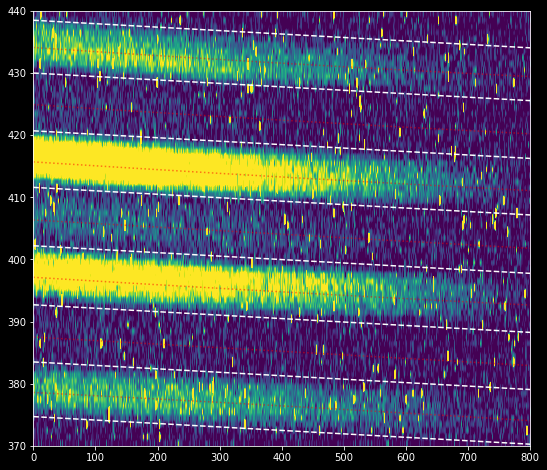

In [62]:
pl.figure(figsize=(10,8))
offset = 0
pl.imshow(jupitermoon_array[ystart+offset:yend+offset, :xend],
          extent=[0,xend,ystart+offset,yend+offset],
          vmin=0, vmax=50,
         )
pl.plot([0,xend], ystart+offset + intertrace_cuts + np.array([0,xend])[:,None] * slope, color='w', linestyle='--')
pl.gca().set_aspect(10)
for tracefit in fitted_polymodels.values():
    pl.plot(xvals[:xend], tracefit(xvals[:xend])+offset, 'r:', alpha=0.5)
pl.axis((0,xend,ystart+offset,yend+offset))

In [63]:
jupitermoon_spectra = {}
for trace_index, polymodel_trace in fitted_polymodels.items():
    trace_center = polymodel_trace(xvals) + offset

    model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
    
    trace_avg_spectrum = np.array([np.average(
            jupitermoon_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
            weights=model_trace_profile)
                               for yval, ii in zip(trace_center, xvals)])

    jupitermoon_spectra[trace_index] = trace_avg_spectrum

(-10.0, 60.0)

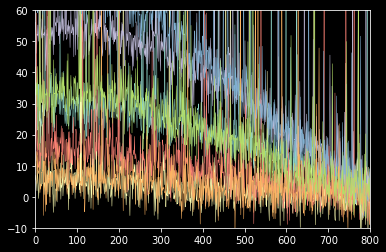

In [64]:
for index in jupitermoon_spectra:
    pl.plot(jupitermoon_spectra[index], linewidth=0.5)
pl.xlim(0,800)
pl.ylim(-10,60)

## Ring Nebula

In [65]:
ring_data = (np.mean([fits.getdata(x) for x in glob.glob('ringnebula_60s00*.FIT')],
                      axis=0))
#- np.median([fits.getdata(x) for x in glob.glob('dark_60s00*.FIT')], axis=0))
ring_array = np.array(ring_data)
ring_array = ring_array - np.median(ring_array)

(800.0, 1500.0)

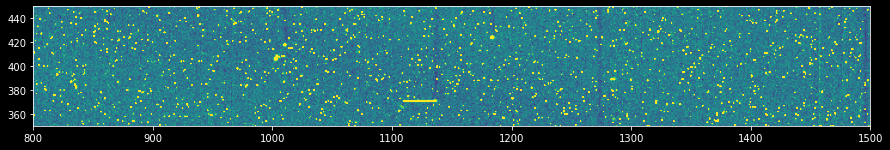

In [66]:
pl.figure(figsize=(15,8))
pl.imshow(ring_array, vmax=50)
pl.ylim(350,450)
pl.xlim(800,1500)

(0.0, 800.0, 371.0, 441.0)

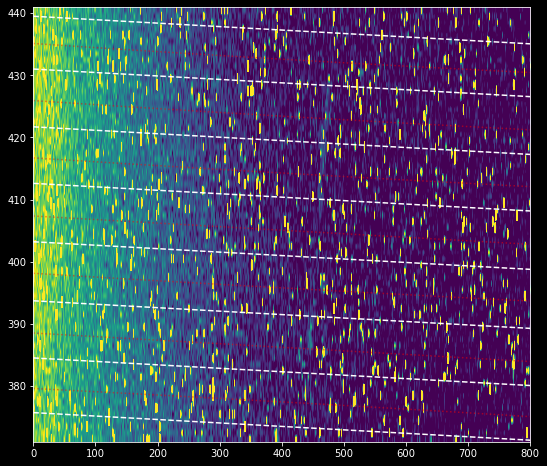

In [67]:
pl.figure(figsize=(10,8))
offset = 1
pl.imshow(ring_array[ystart+offset:yend+offset, :xend],
          extent=[0,xend,ystart+offset,yend+offset],
          vmin=0, vmax=50,
         )
pl.plot([0,xend], ystart+offset + intertrace_cuts + np.array([0,xend])[:,None] * slope, color='w', linestyle='--')
pl.gca().set_aspect(10)
for tracefit in fitted_polymodels.values():
    pl.plot(xvals[:xend], tracefit(xvals[:xend])+offset, 'r:', alpha=0.5)
pl.axis((0,xend,ystart+offset,yend+offset))

In [68]:
ring_spectra = {}
for trace_index, polymodel_trace in fitted_polymodels.items():
    trace_center = polymodel_trace(xvals) + offset

    model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
    
    trace_avg_spectrum = np.array([np.average(
            ring_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
            weights=model_trace_profile)
                               for yval, ii in zip(trace_center, xvals)])

    ring_spectra[trace_index] = trace_avg_spectrum

(-10.0, 4000.0)

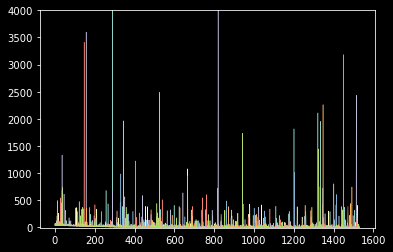

In [69]:
for index in ring_spectra:
    pl.plot(ring_spectra[index], linewidth=0.5)
# pl.xlim(0,800)
pl.ylim(-10,4000)

# Wavelength Calibration

## Helium

(50.0, 600.0)

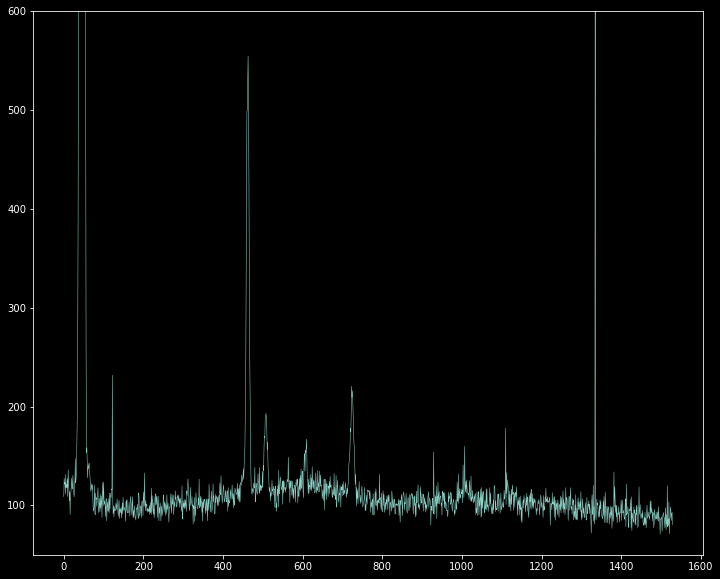

In [70]:
# for index in helium_spectra1:
pl.figure(figsize=(12,10))
pl.plot(helium_spectra1[0], linewidth=0.5)
# pl.xlim(0,800)
pl.ylim(50,600)

In [71]:
guessed_wavelengths_he= [587,501,444, 384]
guessed_xvals_he = [45, 455, 726, 1010]

In [72]:
helium1 = helium_spectra1[0]
xaxis = np.arange(helium_spectra1[0].shape[0])
npixels = 10
improved_xval_guesses_he = [np.average(xaxis[g-npixels:g+npixels],
                                    weights=helium1[g-npixels:g+npixels] - np.median(helium1[0]))
                         for g in guessed_xvals_he]
improved_xval_guesses_he

[47.34557212042267, 460.1584757216735, 724.1273043212267, 1008.5467161632265]

Text(0.5, 1.0, 'Helium Spectrum')

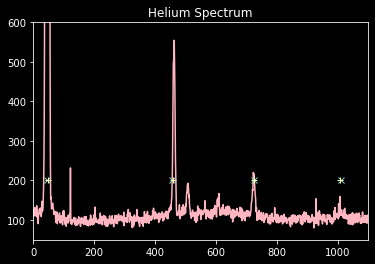

In [73]:
pl.plot(xaxis, helium_spectra1[0], color='lightpink')
pl.plot(guessed_xvals_he, [200]*4, 'x')
pl.plot(improved_xval_guesses_he, [200]*4, '+')
pl.xlim(0,1100)
pl.ylim(50,600)
pl.title('Helium Spectrum')

In [74]:
from astropy.modeling.fitting import LinearLSQFitter
linfitter = LinearLSQFitter()
from astropy.modeling.models import Linear1D
wlmodel = Linear1D()

In [75]:
linfit_wlmodel_he = linfitter(model=wlmodel, x=improved_xval_guesses_he, y=guessed_wavelengths_he)
xaxis_he = np.arange(helium1.shape[0])
wavelengths_he = linfit_wlmodel_he(xaxis) * u.nm

Text(0.5, 1.0, 'Helium Wavelength Solution')

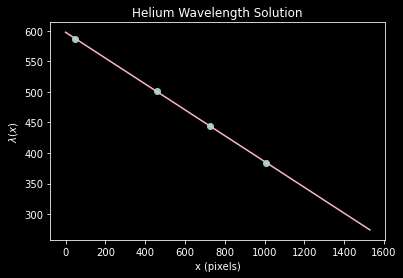

In [76]:
pl.plot(improved_xval_guesses_he, guessed_wavelengths_he, 'o')
pl.plot(xaxis_he, wavelengths_he, '-', color='lightpink')
pl.ylabel("$\lambda(x)$")
pl.xlabel("x (pixels)")
pl.title('Helium Wavelength Solution')

## Neon

### Beginning of Night

(0.0, 500.0)

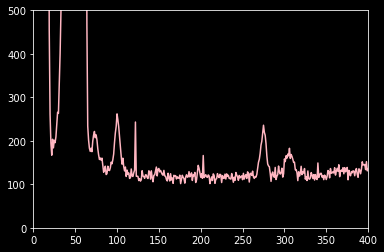

In [77]:
neon1 = neon_spectra1[0]
pl.plot(xaxis, neon1, color='lightpink')
pl.xlim(0,400)
pl.ylim(0,500)

In [78]:
guessed_wavelengths_ne1= [594, 588, 585,576, 539, 532]
guessed_xvals_ne1 = [10, 40, 65, 100, 280, 310]

In [79]:
npixels = 10
improved_xval_guesses_ne1 = [np.average(xaxis[g-npixels:g+npixels],
                                    weights=neon1[g-npixels:g+npixels] - np.median(neon1))
                         for g in guessed_xvals_ne1]
improved_xval_guesses_ne1

[11.093445765150198,
 42.77329458533919,
 58.4308253168663,
 100.1319059524598,
 275.4792764405742,
 306.27772036632217]

Text(0.5, 1.0, 'Neon Spectrum')

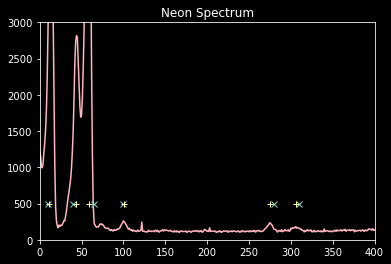

In [80]:
pl.plot(xaxis, neon1, color='lightpink')
pl.plot(guessed_xvals_ne1, [500]*6, 'x')
pl.plot(improved_xval_guesses_ne1, [500]*6, '+')
pl.xlim(0,400)
pl.ylim(0,3000)
pl.title('Neon Spectrum')

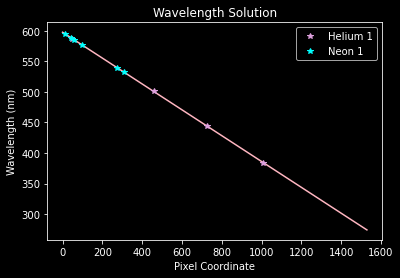

In [81]:
pl.plot(improved_xval_guesses_he, guessed_wavelengths_he, '*', color='plum', label='Helium 1')
pl.plot(improved_xval_guesses_ne1, guessed_wavelengths_ne1, '*', color='cyan', label='Neon 1')
pl.plot(xaxis, wavelengths_he, zorder=-5, color='lightpink')
pl.legend(loc='best')
pl.xlabel("Pixel Coordinate")
pl.ylabel("Wavelength (nm)")
pl.title('Wavelength Solution');

### End of Night

(0.0, 1500.0)

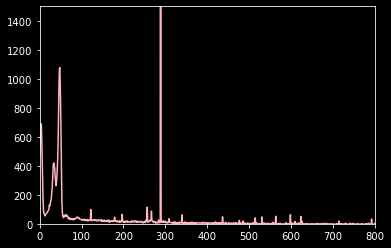

In [82]:
neon2 = neon_spectra2[0]
pl.plot(xaxis, neon2, color='lightpink')
pl.xlim(0,800)
pl.ylim(-0,1500)

In [83]:
guessed_wavelengths_ne2= [588, 585, 576, 539, 532]
guessed_xvals_ne2 = [28, 53, 90, 280, 310]

In [84]:
npixels = 15
improved_xval_guesses_ne2 = [np.average(xaxis[g-npixels:g+npixels],
                                    weights=neon2[g-npixels:g+npixels] - np.median(neon2))
                         for g in guessed_xvals_ne2]
improved_xval_guesses_ne2

[32.03670521305961,
 47.44827611650767,
 89.11608746212298,
 288.1272558652636,
 307.427165615411]

Text(0.5, 1.0, 'Neon Spectrum')

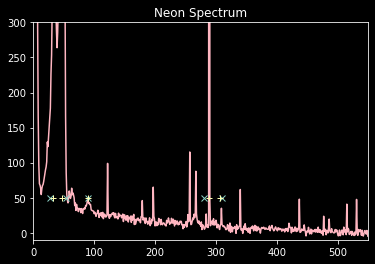

In [85]:
pl.plot(xaxis, neon2, color='lightpink')
pl.plot(guessed_xvals_ne2, [50]*5, 'x')
pl.plot(improved_xval_guesses_ne2, [50]*5, '+')
pl.xlim(0,550)
pl.ylim(-10,300)
pl.title('Neon Spectrum')

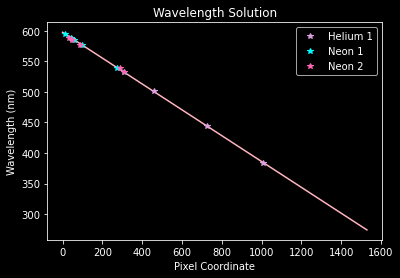

In [86]:
pl.plot(improved_xval_guesses_he, guessed_wavelengths_he, '*', color='plum', label='Helium 1')
pl.plot(improved_xval_guesses_ne1, guessed_wavelengths_ne1, '*', color='cyan', label='Neon 1')
pl.plot(improved_xval_guesses_ne2, guessed_wavelengths_ne2, '*', color='hotpink', label='Neon 2')
pl.plot(xaxis, wavelengths_he, zorder=-5, color='lightpink')
pl.legend(loc='best')
pl.xlabel("Pixel Coordinate")
pl.ylabel("Wavelength (nm)")
pl.title('Wavelength Solution');

In [87]:
xvals_hene = list(improved_xval_guesses_he) + list(improved_xval_guesses_ne1) + list(improved_xval_guesses_ne2) 
waves_hene = list(guessed_wavelengths_he) + list(guessed_wavelengths_ne1) + list(guessed_wavelengths_ne2)
linfit_wlmodel_hene = linfitter(model=wlmodel, x=xvals_hene, y=waves_hene)
linfit_wlmodel_hene

<Linear1D(slope=-0.20980896, intercept=596.46423702)>

# Measuring spectral features of objects

## Vega

In [88]:
vega_line = vega_spectra[1]
wavelengths = linfit_wlmodel_he(xaxis) * u.nm

In [89]:
vega_guess = [410, 434, 488]
npixels = 10
improved_vega_guess = [np.average(xaxis[g-npixels:g+npixels],
                                    weights=vega_line[g-npixels:g+npixels] - np.median(vega_line))
                         for g in vega_guess]
improved_vega_guess

[409.30790165610557, 433.61155109385066, 487.4357255872962]

Text(0.5, 0, 'wavelength')

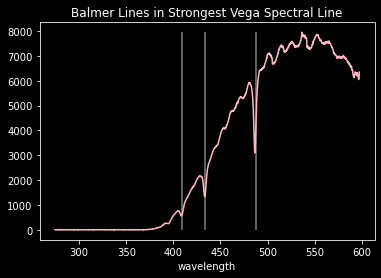

In [90]:
pl.plot(wavelengths, vega_line, color='lightpink')
pl.vlines(x=improved_vega_guess, ymin=0, ymax=max(vega_line), color='grey')
# pl.xlim(150,800)
# pl.ylim(50,350)
pl.title('Balmer Lines in Strongest Vega Spectral Line')
pl.xlabel('wavelength')

Text(0.5, 0, 'Wavelength [nm]')

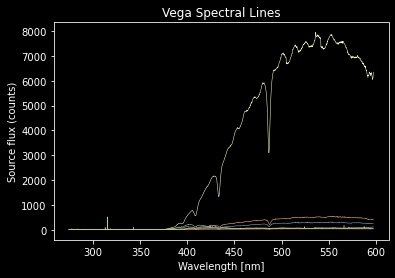

In [91]:
for index in vega_spectra:
    pl.plot(wavelengths,vega_spectra[index], linewidth=0.5)
# pl.xlim(0,800)
pl.title("Vega Spectral Lines")
pl.ylabel("Source flux (counts)")
pl.xlabel("Wavelength [nm]")

Text(0.5, 0, 'Wavelength [nm]')

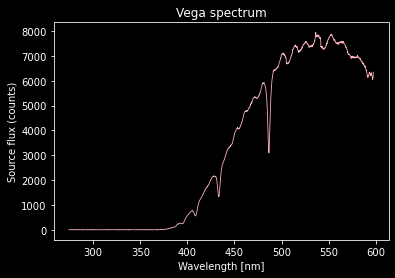

In [92]:
# pl.figure(figsize=(10,8))
vega_line = vega_spectra[1]
wavelengths = linfit_wlmodel_he(xaxis) * u.nm
pl.plot(wavelengths, vega_line, color='lightpink', linewidth=0.8)
pl.title(r"Vega spectrum")
pl.ylabel("Source flux (counts)")
pl.xlabel("Wavelength [nm]")

### Flat Fielding with H Beta

Text(0.5, 0, 'Wavelength [nm]')

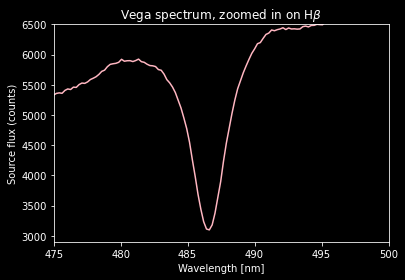

In [93]:
# pl.figure(figsize=(10,8))
vega_line = vega_spectra[1]
wavelengths = linfit_wlmodel_he(xaxis) * u.nm
pl.plot(wavelengths, vega_line, color='lightpink')
pl.xlim(475,500)
pl.ylim(2900,6500)
pl.title(r"Vega spectrum, zoomed in on H$\beta$")
pl.ylabel("Source flux (counts)")
pl.xlabel("Wavelength [nm]")

In [94]:
from astropy.modeling.fitting import LinearLSQFitter, LevMarLSQFitter
from astropy.modeling.models import Gaussian1D, Linear1D

In [95]:
selection = (((wavelengths > 475*u.nm) & (wavelengths < 482*u.nm)) |
             ((wavelengths > 490*u.nm) & (wavelengths < 497*u.nm)))
linfitter = LinearLSQFitter()
continuum_model_fit = linfitter(Linear1D(), wavelengths[selection],
                                vega_line[selection])
continuum_model_fit

<Linear1D(slope=52.63080782 1 / nm, intercept=-19519.68354431 )>

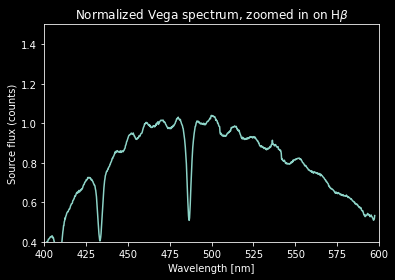

In [96]:
pl.title("Normalized Vega spectrum, zoomed in on H$\\beta$")
pl.ylabel("Source flux (counts)")
pl.xlabel("Wavelength [nm]")
pl.xlim(400, 600)
pl.ylim(0.4, 1.5)
pl.plot(wavelengths, vega_line / continuum_model_fit(wavelengths));

In [97]:
absorption_only_profile = vega_line / continuum_model_fit(wavelengths) - 1
selection = ((wavelengths > 482*u.nm) & (wavelengths < 491*u.nm))
guesses = [-0.5, 487, 3] # eyeballed
lmfitter = LevMarLSQFitter()
hbeta_line_fit = lmfitter(Gaussian1D(*guesses), wavelengths[selection],
                          absorption_only_profile[selection])
hbeta_line_fit

<Gaussian1D(amplitude=-0.47072643 , mean=486.55600107 nm, stddev=1.3314538 nm)>

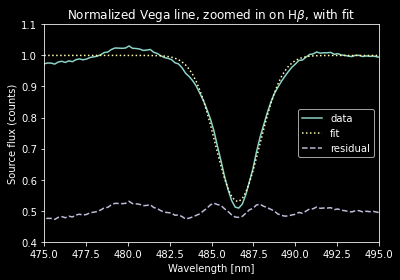

In [98]:
pl.title("Normalized Vega line, zoomed in on H$\\beta$, with fit")
pl.ylabel("Source flux (counts)")
pl.xlabel("Wavelength [nm]")
pl.xlim(475, 495)
pl.ylim(0.4, 1.1)
pl.plot(wavelengths, vega_line / continuum_model_fit(wavelengths), label='data');
pl.plot(wavelengths, hbeta_line_fit(wavelengths) + 1, linestyle=':', label='fit')
pl.plot(wavelengths, vega_line / continuum_model_fit(wavelengths) - (hbeta_line_fit(wavelengths) + 1) + 0.5, linestyle='--', label='residual')
pl.legend(loc='best');

In [99]:
# rescale model to original
model_hbeta_line_profile = hbeta_line_fit(wavelengths[selection]) * continuum_model_fit(wavelengths[selection])
# subtract from original
vega_spectrum_minus_hbeta = vega_line.copy()
vega_spectrum_minus_hbeta[selection] -= model_hbeta_line_profile.value

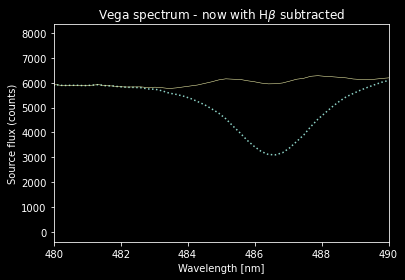

In [100]:
pl.title("Vega spectrum - now with H$\\beta$ subtracted")
pl.ylabel("Source flux (counts)")
pl.xlabel("Wavelength [nm]")
pl.xlim(480,490)
pl.plot(wavelengths, vega_line, linestyle=':');
pl.plot(wavelengths, vega_spectrum_minus_hbeta, linewidth=0.5);

In [101]:
# moment analysis hbeta
delta_nu = wavelengths[1] - wavelengths[0]
m0 = (vega_spectrum_minus_hbeta[selection] * delta_nu).sum()
m1 = (wavelengths[selection] * vega_spectrum_minus_hbeta[selection] * delta_nu).sum() / m0
m2 = ((wavelengths[selection] - m1)**2 * vega_spectrum_minus_hbeta[selection] * delta_nu).sum() / m0
sigma = m2**0.5
vel = sigma / m1 * constants.c
m0,m1,m2,m2**0.5, vel

(<Quantity -53840.65656045 nm>,
 <Quantity 486.57735699 nm>,
 <Quantity 6.54032609 nm2>,
 <Quantity 2.55740612 nm>,
 <Quantity 1575681.76393557 m / s>)

1.571030505592436 nm


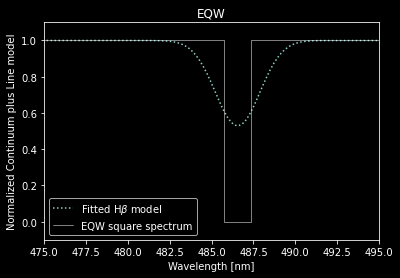

In [102]:
# equivalent width
pl.title("EQW")
pl.ylabel("Normalized Continuum plus Line model")
pl.xlabel("Wavelength [nm]")
pl.xlim(475, 495)
pl.ylim(-0.1, 1.1)
eqw_hbeta = - hbeta_line_fit.amplitude * (2*np.pi)**0.5 * hbeta_line_fit.stddev
#pl.plot(wavelengths, vega_spectrum / continuum_model_fit(wavelengths), label='data');
pl.plot(wavelengths, hbeta_line_fit(wavelengths) + 1, linestyle=':', label='Fitted H$\\beta$ model')
pl.plot(u.Quantity([450*u.nm, hbeta_line_fit.mean - eqw_hbeta/2, hbeta_line_fit.mean - eqw_hbeta/2,
         hbeta_line_fit.mean + eqw_hbeta/2, hbeta_line_fit.mean + eqw_hbeta/2, 500*u.nm]),
        [1, 1, 0, 0, 1, 1],
        color='w', linewidth=0.5, label='EQW square spectrum')
pl.legend(loc='best');
print(eqw_hbeta)

### h delta

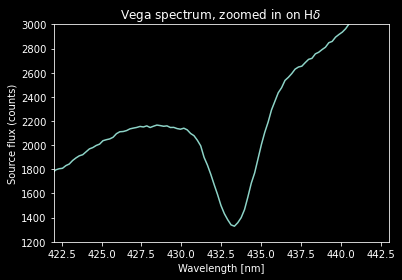

In [103]:
pl.title(r"Vega spectrum, zoomed in on H$\delta$")
pl.ylabel("Source flux (counts)")
pl.xlabel("Wavelength [nm]")
pl.xlim(422, 443)
pl.ylim(1200, 3000)
pl.plot(wavelengths, vega_line);

In [104]:
vega_spectrum_minus_lines = vega_spectrum_minus_hbeta.copy()

In [105]:
selection = (((wavelengths > 422*u.nm) & (wavelengths < 430*u.nm)) |
             ((wavelengths > 437*u.nm) & (wavelengths < 442.5*u.nm)))
linfitter = LinearLSQFitter()
continuum_model_fit = linfitter(Linear1D(), wavelengths[selection], vega_line[selection])
continuum_model_fit

<Linear1D(slope=63.08795247 1 / nm, intercept=-24836.14194249 )>

In [106]:
absorption_only_profile = vega_line / continuum_model_fit(wavelengths) - 1
selection = ((wavelengths > 426*u.nm) & (wavelengths < 437.5*u.nm))
guesses = [-0.5, 434, 3.5] # guessed
lmfitter = LevMarLSQFitter()
hdelta_line_fit = lmfitter(Gaussian1D(*guesses), wavelengths[selection], absorption_only_profile[selection])
model_hdelta_line_profile = hdelta_line_fit(wavelengths[selection]) * continuum_model_fit(wavelengths[selection])
vega_spectrum_minus_lines[selection] -= model_hdelta_line_profile.value
hdelta_line_fit

<Gaussian1D(amplitude=-0.45113835 , mean=433.33084835 nm, stddev=1.54014902 nm)>

In [107]:
# moment analysis hdelta
delta_nu = wavelengths[1] - wavelengths[0]
m0 = (model_hdelta_line_profile * delta_nu).sum()
m1 = (wavelengths[selection] * model_hdelta_line_profile * delta_nu).sum() / m0
m2 = ((wavelengths[selection] - m1)**2 * model_hdelta_line_profile * delta_nu).sum() / m0
sigma = m2**0.5
vel = sigma / m1 * constants.c
m0,m1,m2,m2**0.5, vel

(<Quantity 4339.52511995 nm>,
 <Quantity 433.3720274 nm>,
 <Quantity 2.29211401 nm2>,
 <Quantity 1.51397292 nm>,
 <Quantity 1047316.4741476 m / s>)

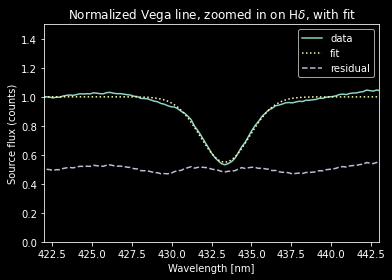

In [108]:
pl.title("Normalized Vega line, zoomed in on H$\\delta$, with fit")
pl.ylabel("Source flux (counts)")
pl.xlabel("Wavelength [nm]")
pl.xlim(422, 443)
pl.ylim(0, 1.5)
pl.plot(wavelengths, vega_line / continuum_model_fit(wavelengths), label='data');
pl.plot(wavelengths, hdelta_line_fit(wavelengths) + 1, linestyle=':', label='fit')
pl.plot(wavelengths, vega_line / continuum_model_fit(wavelengths) - (hdelta_line_fit(wavelengths) + 1) + 0.5, linestyle='--', label='residual')
pl.legend(loc='best');

1.7416561561581785 nm


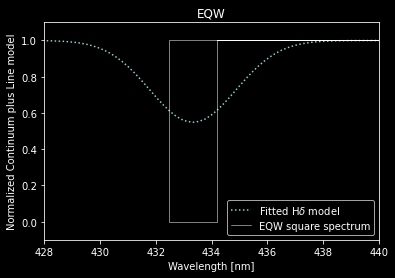

In [109]:
# equivalent width
pl.title("EQW")
pl.ylabel("Normalized Continuum plus Line model")
pl.xlabel("Wavelength [nm]")
pl.xlim(428, 440)
pl.ylim(-0.1, 1.1)
eqw_hdelta = - hdelta_line_fit.amplitude * (2*np.pi)**0.5 * hdelta_line_fit.stddev
#pl.plot(wavelengths, vega_spectrum / continuum_model_fit(wavelengths), label='data');
pl.plot(wavelengths, hdelta_line_fit(wavelengths) + 1, linestyle=':', label='Fitted H$\\delta$ model')
pl.plot(u.Quantity([450*u.nm, hdelta_line_fit.mean - eqw_hdelta/2, hdelta_line_fit.mean - eqw_hdelta/2,
         hdelta_line_fit.mean + eqw_hdelta/2, hdelta_line_fit.mean + eqw_hdelta/2, 500*u.nm]),
        [1, 1, 0, 0, 1, 1],
        color='w', linewidth=0.5, label='EQW square spectrum')
pl.legend(loc='best');
print(eqw_hdelta)

### h gamma

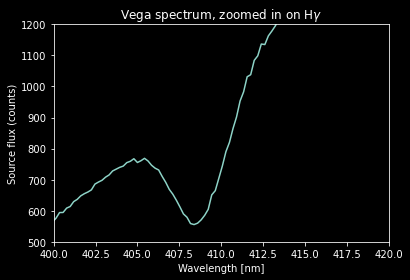

In [110]:
pl.title(r"Vega spectrum, zoomed in on H$\gamma$")
pl.ylabel("Source flux (counts)")
pl.xlabel("Wavelength [nm]")
pl.xlim(400, 420)
pl.ylim(500, 1200)
pl.plot(wavelengths, vega_line);

In [111]:
selection = (((wavelengths > 400*u.nm) & (wavelengths < 404.5*u.nm)) |
             ((wavelengths > 414*u.nm) & (wavelengths < 420*u.nm)))
linfitter = LinearLSQFitter()
continuum_model_fit = linfitter(Linear1D(), wavelengths[selection], vega_line[selection])
continuum_model_fit

<Linear1D(slope=54.4120822 1 / nm, intercept=-21221.04851507 )>

In [112]:
absorption_only_profile = vega_line/ continuum_model_fit(wavelengths) - 1
selection = ((wavelengths > 404.5*u.nm) & (wavelengths < 414*u.nm))
guesses = [-0.5, 408, 3] # guessed
lmfitter = LevMarLSQFitter()
hgamma_line_fit = lmfitter(Gaussian1D(*guesses), wavelengths[selection], absorption_only_profile[selection])
model_hgamma_line_profile = hgamma_line_fit(wavelengths[selection]) * continuum_model_fit(wavelengths[selection])
vega_spectrum_minus_lines[selection] -= model_hgamma_line_profile.value
hgamma_line_fit

<Gaussian1D(amplitude=-0.43407025 , mean=408.6925508 nm, stddev=1.86821236 nm)>

In [113]:
# moment analysis hgamma
gamma_nu = wavelengths[1] - wavelengths[0]
m0 = (model_hgamma_line_profile * gamma_nu).sum()
m1 = (wavelengths[selection] * model_hgamma_line_profile * gamma_nu).sum() / m0
m2 = ((wavelengths[selection] - m1)**2 * model_hgamma_line_profile * gamma_nu).sum() / m0
sigma = m2**0.5
vel = sigma / m1 * constants.c
m0,m1,m2,m2**0.5, vel

(<Quantity 2042.39275871 nm>,
 <Quantity 408.90692769 nm>,
 <Quantity 3.16873694 nm2>,
 <Quantity 1.78009464 nm>,
 <Quantity 1305086.59125006 m / s>)

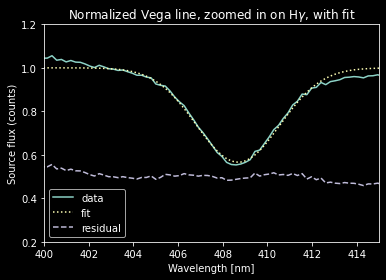

In [114]:
pl.title("Normalized Vega line, zoomed in on H$\\gamma$, with fit")
pl.ylabel("Source flux (counts)")
pl.xlabel("Wavelength [nm]")
pl.xlim(400, 415)
pl.ylim(0.2, 1.2)
pl.plot(wavelengths, vega_line / continuum_model_fit(wavelengths), label='data');
pl.plot(wavelengths, hgamma_line_fit(wavelengths) + 1, linestyle=':', label='fit')
pl.plot(wavelengths, vega_line / continuum_model_fit(wavelengths) - (hgamma_line_fit(wavelengths) + 1) + 0.5, linestyle='--', label='residual')
pl.legend(loc='best');

2.032713626817751 nm


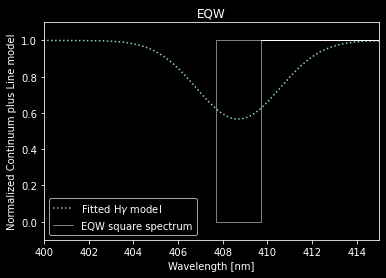

In [115]:
# equivalent width
pl.title("EQW")
pl.ylabel("Normalized Continuum plus Line model")
pl.xlabel("Wavelength [nm]")
pl.xlim(400, 415)
pl.ylim(-0.1, 1.1)
eqw_hgamma = - hgamma_line_fit.amplitude * (2*np.pi)**0.5 * hgamma_line_fit.stddev
#pl.plot(wavelengths, vega_spectrum / continuum_model_fit(wavelengths), label='data');
pl.plot(wavelengths, hgamma_line_fit(wavelengths) + 1, linestyle=':', label='Fitted H$\\gamma$ model')
pl.plot(u.Quantity([450*u.nm, hgamma_line_fit.mean - eqw_hgamma/2, hgamma_line_fit.mean - eqw_hgamma/2,
         hgamma_line_fit.mean + eqw_hgamma/2, hgamma_line_fit.mean + eqw_hgamma/2, 500*u.nm]),
        [1, 1, 0, 0, 1, 1],
        color='w', linewidth=0.5, label='EQW square spectrum')
pl.legend(loc='best');
print(eqw_hgamma)

### combined

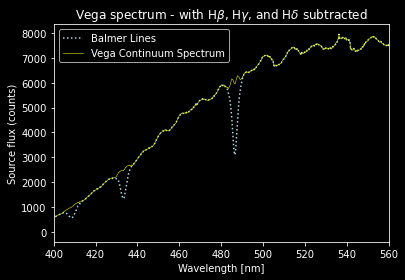

In [116]:
pl.title("Vega spectrum - with H$\\beta$, H$\\gamma$, and H$\\delta$ subtracted")
pl.ylabel("Source flux (counts)")
pl.xlabel("Wavelength [nm]")
pl.xlim(400,560)
pl.plot(wavelengths, vega_line, linestyle=':', label='Balmer Lines', color='lightblue');
pl.plot(wavelengths, vega_spectrum_minus_lines, linewidth=0.5, label='Vega Continuum Spectrum', color='yellow');
pl.legend(loc='best');

## Altair

Text(0.5, 0, 'Wavelength [nm]')

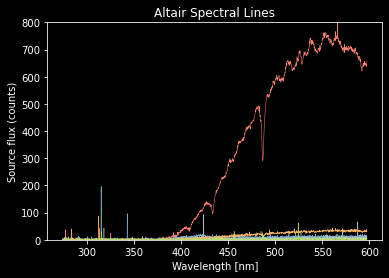

In [117]:
for index in altair_spectra:
    pl.plot(wavelengths, altair_spectra[index], linewidth=0.5)
pl.ylim(0,800)
pl.title("Altair Spectral Lines")
pl.ylabel("Source flux (counts)")
pl.xlabel("Wavelength [nm]")

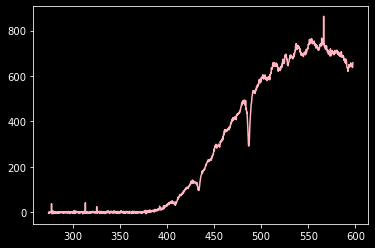

In [118]:
altair_line = altair_spectra[3]
wavelengths = linfit_wlmodel_he(xaxis) * u.nm
pl.plot(wavelengths, altair_line, color='lightpink')
# pl.xlim(0,800)
# pl.ylim(-0,1500)

In [119]:
altair_guess = [410, 434, 488]
npixels = 10
improved_altair_guess = [np.average(xaxis[g-npixels:g+npixels],
                                    weights=altair_line[g-npixels:g+npixels] - np.median(altair_line))
                         for g in altair_guess]
improved_altair_guess

[409.24758764339884, 433.5429435939928, 487.3560089716015]

Text(0.5, 0, 'Wavelength [nm]')

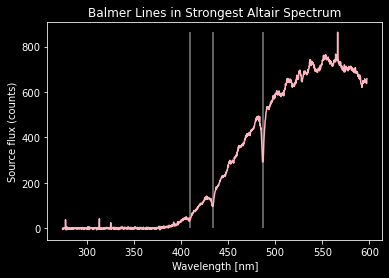

In [120]:
pl.plot(wavelengths, altair_line, color='lightpink')
pl.vlines(x=improved_altair_guess, ymin=0, ymax=max(altair_line), color='grey')
# pl.xlim(150,800)
# pl.ylim(50,350)
pl.title('Balmer Lines in Strongest Altair Spectrum')
pl.ylabel("Source flux (counts)")
pl.xlabel("Wavelength [nm]")

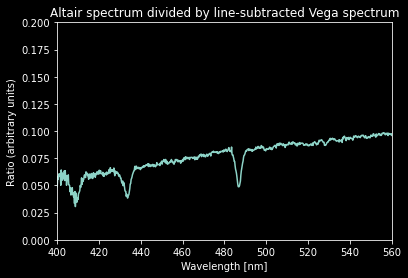

In [121]:
pl.title("Altair spectrum divided by line-subtracted Vega spectrum")
pl.ylabel("Ratio (arbitrary units)")
pl.xlabel("Wavelength [nm]")
pl.xlim(400, 560)
pl.ylim(0, 0.2)
pl.plot(wavelengths, altair_line / vega_spectrum_minus_lines);

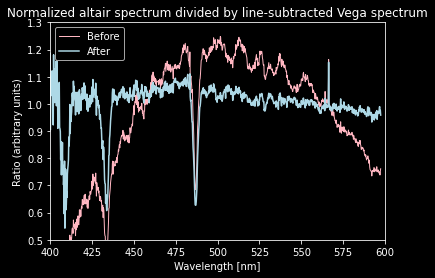

In [122]:
pl.title("Normalized altair spectrum divided by line-subtracted Vega spectrum")
pl.ylabel("Ratio (arbitrary units)")
pl.xlabel("Wavelength [nm]")
pl.xlim(400, 600)
pl.ylim(0.5, 1.3)
selection = wavelengths>400*u.nm
altair_linmod = linfitter(Linear1D(), wavelengths[selection], altair_line[selection])
altair_div_vega_linmod = linfitter(Linear1D(), wavelengths[selection], (altair_line / vega_spectrum_minus_lines)[selection])
pl.plot(wavelengths, altair_line / altair_linmod(wavelengths), label='Before', linewidth=1, color='lightpink');
pl.plot(wavelengths, altair_line / vega_spectrum_minus_lines / altair_div_vega_linmod(wavelengths), label='After', color='lightblue');
pl.legend(loc='best');

(400.0, 500.0)

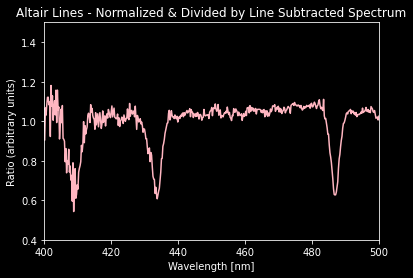

In [123]:
altair_fixed = (altair_line / vega_spectrum_minus_lines / altair_div_vega_linmod(wavelengths))
pl.plot(wavelengths, altair_fixed, color='lightpink');
pl.title('Altair Lines - Normalized & Divided by Line Subtracted Spectrum')
pl.ylabel("Ratio (arbitrary units)")
pl.xlabel("Wavelength [nm]")
pl.ylim(0.4,1.5)
pl.xlim(400,500)

In [124]:
# moment analysis hbeta
selection_beta = ((wavelengths > 484*u.nm) & (wavelengths < 490*u.nm))
beta_nu = wavelengths[1] - wavelengths[0]
m0 = (altair_fixed[selection_beta] * beta_nu).sum()
m1 = (wavelengths[selection_beta] * altair_fixed[selection_beta] * beta_nu).sum() / m0
m2 = ((wavelengths[selection_beta] - m1)**2 * altair_fixed[selection_beta] * beta_nu).sum() / m0
sigma = m2**0.5
vel = sigma / m1 * constants.c
print('Moments: ',m0,m1,m2,m2**0.5, vel)

# equivalent width
# eqw_hbeta = -altair_div_vega_linmod(wavelengths[selection]).amplitude * (2*np.pi)**0.5 * altair_linmod.stddev
# eqw_hbeta

Moments:  -4.910167760543258 nm 486.9481617535936 nm 3.302331024486676 nm2 1.8172316925716092 nm 1118789.223702255 m / s


In [125]:
# moment analysis hdelta
selection_delta = ((wavelengths > 429*u.nm) & (wavelengths < 437.5*u.nm))
delta_nu = wavelengths[1] - wavelengths[0]
m0 = (altair_fixed[selection_delta] * delta_nu).sum()
m1 = (wavelengths[selection_delta] * altair_fixed[selection_delta] * delta_nu).sum() / m0
m2 = ((wavelengths[selection_delta] - m1)**2 * altair_fixed[selection_delta] * delta_nu).sum() / m0
sigma = m2**0.5
vel = sigma / m1 * constants.c
print('Moments: ',m0,m1,m2,m2**0.5, vel)

# equivalent width
# eqw_hdelta = - hdelta_line_fit.amplitude * (2*np.pi)**0.5 * hdelta_line_fit.stddev
# print('EQW: ', eqw_hdelta)

Moments:  -7.092545032894114 nm 433.2344918141095 nm 6.696729850118741 nm2 2.5878040594524814 nm 1790725.7027414069 m / s


In [126]:
# moment analysis hgamma
selection_gamma = ((wavelengths > 403*u.nm) & (wavelengths < 414*u.nm))
gamma_nu = wavelengths[1] - wavelengths[0]
m0 = (altair_fixed[selection_gamma] * gamma_nu).sum()
m1 = (wavelengths[selection_gamma] * altair_fixed[selection_gamma] * gamma_nu).sum() / m0
m2 = ((wavelengths[selection_gamma] - m1)**2 * altair_fixed[selection_gamma] * gamma_nu).sum() / m0
sigma = m2**0.5
vel = sigma / m1 * constants.c
print('Moments: ',m0,m1,m2,m2**0.5, vel)

# equivalent width
# eqw_hgamma = - hgamma_line_fit.amplitude * (2*np.pi)**0.5 * hgamma_line_fit.stddev
# print('EQW: ', eqw_hgamma)

Moments:  -9.647473944647217 nm 408.38448306306026 nm 11.41099807870499 nm2 3.3780168854973165 nm 2479780.763639762 m / s


Text(0.5, 0, 'Wavelength [nm]')

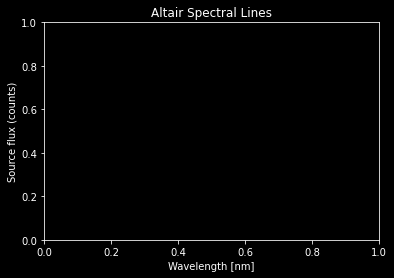

In [127]:
pl.title("Altair Spectral Lines")
pl.ylabel("Source flux (counts)")
pl.xlabel("Wavelength [nm]")

## Jupiter

Text(0.5, 0, 'Wavelength [nm]')

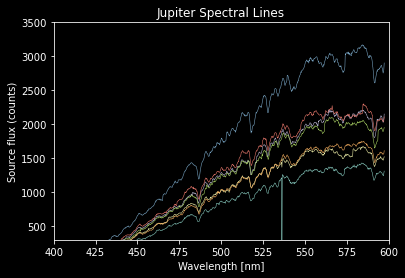

In [128]:
for index in jupiter_spectra:
    pl.plot(wavelengths, jupiter_spectra[index], linewidth=0.5)
pl.xlim(400,600)
pl.ylim(300,3500)
pl.title("Jupiter Spectral Lines")
pl.ylabel("Source flux (counts)")
pl.xlabel("Wavelength [nm]")

(425.0, 600.0)

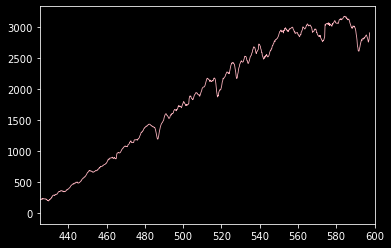

In [129]:
jupiter_line = jupiter_spectra[4]
wavelengths = linfit_wlmodel_he(xaxis) * u.nm
pl.plot(wavelengths, jupiter_line, color='lightpink', linewidth=0.8)
pl.xlim(425,600)
# pl.ylim(-0,1500)

In [130]:
jupiter_guess = [430, 487, 520, 528, 546, 562, 573, 592]
npixels = 10
improved_jupiter_guess = [np.average(xaxis[g-npixels:g+npixels],
                                    weights=jupiter_line[g-npixels:g+npixels] - np.median(jupiter_line))
                         for g in jupiter_guess]
improved_jupiter_guess

[429.41546215665886,
 486.2927460842874,
 519.0250697400685,
 527.7790819851065,
 545.4746309998534,
 561.1312869767002,
 572.2364756322097,
 591.314322180552]

Text(0.5, 0, 'Wavelength [nm]')

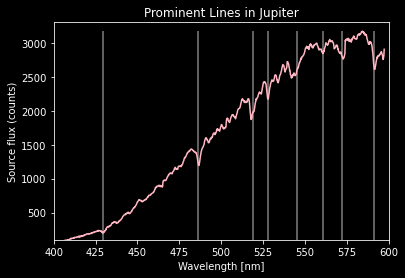

In [131]:
pl.plot(wavelengths, jupiter_line, color='lightpink')
pl.vlines(x=improved_jupiter_guess, ymin=0, ymax=max(jupiter_line), color='grey')
pl.xlim(400,600)
# pl.xlim(400,600)
pl.ylim(100,3300)
pl.title('Prominent Lines in Jupiter')
pl.ylabel("Source flux (counts)")
pl.xlabel("Wavelength [nm]")

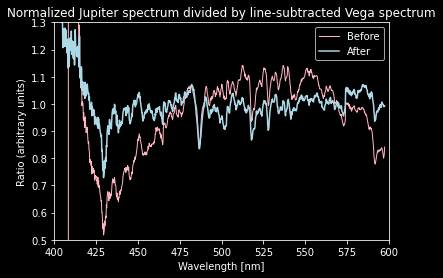

In [132]:
pl.title("Normalized Jupiter spectrum divided by line-subtracted Vega spectrum")
pl.ylabel("Ratio (arbitrary units)")
pl.xlabel("Wavelength [nm]")
pl.xlim(400, 600)
pl.ylim(0.5, 1.3)
selection = wavelengths>400*u.nm
jupiter_linmod = linfitter(Linear1D(), wavelengths[selection], jupiter_line[selection])
jupiter_div_vega_linmod = linfitter(Linear1D(), wavelengths[selection], (jupiter_line / vega_spectrum_minus_lines)[selection])
pl.plot(wavelengths, jupiter_line / jupiter_linmod(wavelengths), label='Before', linewidth=1, color='lightpink');
pl.plot(wavelengths, jupiter_line / vega_spectrum_minus_lines / jupiter_div_vega_linmod(wavelengths), label='After', color='lightblue');
pl.legend(loc='best');

In [133]:
# moment analysis wavelength~430 nm
jupiter_fixed = (jupiter_line / vega_spectrum_minus_lines / jupiter_div_vega_linmod(wavelengths))
selection_430 = ((wavelengths > 428*u.nm) & (wavelengths < 432*u.nm))
nu_430 = wavelengths[1] - wavelengths[0]
m0 = (jupiter_fixed[selection_430] * nu_430).sum()
m1 = (wavelengths[selection_430] * jupiter_fixed[selection_430] * nu_430).sum() / m0
m2 = ((wavelengths[selection_430] - m1)**2 * jupiter_fixed[selection_430] * nu_430).sum() / m0
sigma = m2**0.5
vel = sigma / m1 * constants.c
print('Moments: ',m0,m1,m2,m2**0.5, vel)

# equivalent width
# eqw_hbeta = -jupiter_div_vega_linmod(wavelengths[selection]).amplitude * (2*np.pi)**0.5 * jupiter_linmod.stddev
# eqw_hbeta

Moments:  -3.258201434499451 nm 429.9629594950064 nm 1.4116556021708278 nm2 1.188131138456874 nm 828426.6041025366 m / s


In [134]:
# moment analysis wavelength~486 nm
selection_486 = ((wavelengths > 483*u.nm) & (wavelengths < 491*u.nm))
nu_486 = wavelengths[1] - wavelengths[0]
m0 = (jupiter_fixed[selection_486] * nu_486).sum()
m1 = (wavelengths[selection_486] * jupiter_fixed[selection_486] * nu_486).sum() / m0
m2 = ((wavelengths[selection_486] - m1)**2 * jupiter_fixed[selection_486] * nu_486).sum() / m0
sigma = m2**0.5
vel = sigma / m1 * constants.c
print('Moments: ',m0,m1,m2,m2**0.5, vel)

# equivalent width
# eqw_hbeta = -jupiter_div_vega_linmod(wavelengths[selection]).amplitude * (2*np.pi)**0.5 * jupiter_linmod.stddev
# eqw_hbeta

Moments:  -7.6768821081773435 nm 486.92621190719166 nm 5.679345618992128 nm2 2.3831377675225007 nm 1467258.717249703 m / s


In [135]:
# moment analysis wavelength~519 nm
selection_519 = ((wavelengths > 516*u.nm) & (wavelengths < 521*u.nm))
nu_519 = wavelengths[1] - wavelengths[0]
m0 = (jupiter_fixed[selection_519] * nu_519).sum()
m1 = (wavelengths[selection_519] * jupiter_fixed[selection_519] * nu_519).sum() / m0
m2 = ((wavelengths[selection_519] - m1)**2 * jupiter_fixed[selection_519] * nu_519).sum() / m0
sigma = m2**0.5
vel = sigma / m1 * constants.c
print('Moments: ',m0,m1,m2,m2**0.5, vel)

# equivalent width
# eqw_hbeta = -jupiter_div_vega_linmod(wavelengths[selection]).amplitude * (2*np.pi)**0.5 * jupiter_linmod.stddev
# eqw_hbeta

Moments:  -4.7149269336490764 nm 518.4266344828603 nm 2.2150333567633367 nm2 1.4882988129953396 nm 860643.9748826338 m / s


In [136]:
# moment analysis wavelength~527 nm
selection_527 = ((wavelengths > 526*u.nm) & (wavelengths < 530*u.nm))
nu_527 = wavelengths[1] - wavelengths[0]
m0 = (jupiter_fixed[selection_527] * nu_527).sum()
m1 = (wavelengths[selection_527] * jupiter_fixed[selection_527] * nu_527).sum() / m0
m2 = ((wavelengths[selection_527] - m1)**2 * jupiter_fixed[selection_527] * nu_527).sum() / m0
sigma = m2**0.5
vel = sigma / m1 * constants.c
print('Moments: ',m0,m1,m2,m2**0.5, vel)

# equivalent width
# eqw_hbeta = -jupiter_div_vega_linmod(wavelengths[selection]).amplitude * (2*np.pi)**0.5 * jupiter_linmod.stddev
# eqw_hbeta

Moments:  -3.8868058529989113 nm 528.0667657688363 nm 1.3805650911017415 nm2 1.1749745065752455 nm 667052.9528603746 m / s


In [137]:
# moment analysis wavelength~591 nm
selection_591 = ((wavelengths > 590*u.nm) & (wavelengths < 594*u.nm))
nu_591 = wavelengths[1] - wavelengths[0]
m0 = (jupiter_fixed[selection_591] * nu_591).sum()
m1 = (wavelengths[selection_591] * jupiter_fixed[selection_591] * nu_591).sum() / m0
m2 = ((wavelengths[selection_591] - m1)**2 * jupiter_fixed[selection_591] * nu_591).sum() / m0
sigma = m2**0.5
vel = sigma / m1 * constants.c
print('Moments: ',m0,m1,m2,m2**0.5, vel)

# equivalent width
# eqw_hbeta = -jupiter_div_vega_linmod(wavelengths[selection]).amplitude * (2*np.pi)**0.5 * jupiter_linmod.stddev
# eqw_hbeta

Moments:  -3.9195518871411053 nm 591.9097843087487 nm 1.3670352859503532 nm2 1.1692028420895808 nm 592181.7871957764 m / s


(400.0, 600.0)

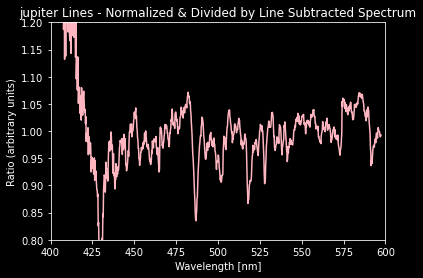

In [138]:
jupiter_fixed = (jupiter_line / vega_spectrum_minus_lines / jupiter_div_vega_linmod(wavelengths))
pl.plot(wavelengths, jupiter_fixed, color='lightpink');
pl.title('jupiter Lines - Normalized & Divided by Line Subtracted Spectrum')
pl.ylabel("Ratio (arbitrary units)")
pl.xlabel("Wavelength [nm]")
pl.ylim(0.8, 1.2)
pl.xlim(400,600)

## Io

Text(0.5, 0, 'Wavelength [nm]')

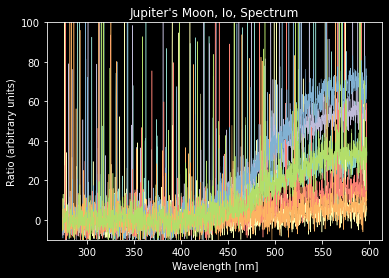

In [139]:
for index in jupitermoon_spectra:
    pl.plot(wavelengths, jupitermoon_spectra[index], linewidth=0.5)
pl.ylim(-10,100)
pl.title("Jupiter's Moon, Io, Spectrum")
pl.ylabel("Ratio (arbitrary units)")
pl.xlabel("Wavelength [nm]")

Text(0.5, 0, 'Wavelength [nm]')

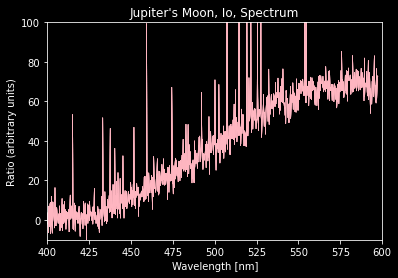

In [140]:
for index in jupitermoon_spectra:
    pl.plot(wavelengths, jupitermoon_spectra[4], linewidth=0.5, color='lightpink')
pl.ylim(-10,100)
pl.xlim(400,600)
pl.title("Jupiter's Moon, Io, Spectrum")
pl.ylabel("Ratio (arbitrary units)")
pl.xlabel("Wavelength [nm]")

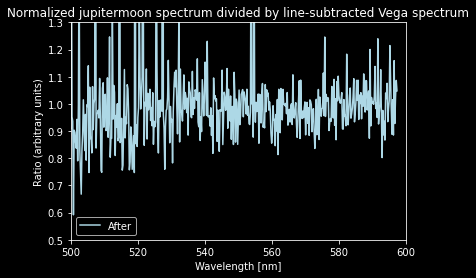

In [141]:
pl.title("Normalized jupitermoon spectrum divided by line-subtracted Vega spectrum")
pl.ylabel("Ratio (arbitrary units)")
pl.xlabel("Wavelength [nm]")
pl.xlim(500, 600)
pl.ylim(0.5, 1.3)
selection = wavelengths>400*u.nm
jupitermoon_linmod = linfitter(Linear1D(), wavelengths[selection], jupitermoon_spectra[4][selection])
jupitermoon_div_vega_linmod = linfitter(Linear1D(), wavelengths[selection], (jupitermoon_spectra[4] / vega_spectrum_minus_lines)[selection])
# pl.plot(wavelengths, jupitermoon_spectra[4] / jupitermoon_linmod(wavelengths), label='Before', linewidth=1, color='lightpink');
pl.plot(wavelengths, jupitermoon_spectra[4] / vega_spectrum_minus_lines / jupitermoon_div_vega_linmod(wavelengths), label='After', color='lightblue');
pl.legend(loc='best');

Lines are too faint to see anything

## Flats / Solar Spectrum

Text(0.5, 0, 'Wavelength [nm]')

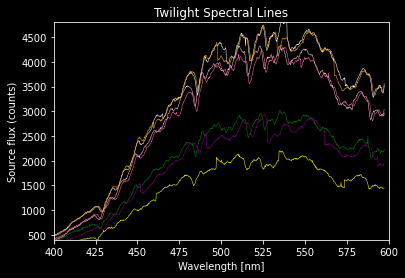

In [142]:
colors = ['yellow', 'pink', 'green', 'hotpink', 'white', 'orange', 'purple']
for index in flats_spectra:
    pl.plot(wavelengths, flats_spectra[index], linewidth=0.5, color=colors[index])
pl.xlim(400,600)
pl.ylim(400,4800)
pl.title("Twilight Spectral Lines")
pl.ylabel("Source flux (counts)")
pl.xlabel("Wavelength [nm]")

(500.0, 4500.0)

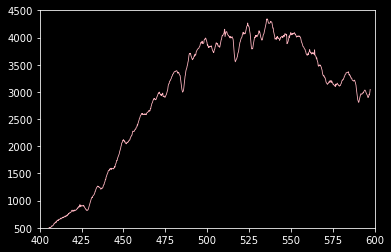

In [143]:
flats_line = flats_spectra[3]
wavelengths = linfit_wlmodel_he(xaxis) * u.nm
pl.plot(wavelengths, flats_line, color='lightpink', linewidth=0.8)
pl.xlim(400,600)
pl.ylim(500,4500)

In [144]:
flats_guess = [430, 439, 445, 452, 487, 518, 528, 542, 591]
npixels = 10
improved_flats_guess = [np.average(xaxis[g-npixels:g+npixels],
                                    weights=flats_line[g-npixels:g+npixels] - np.median(flats_line))
                         for g in flats_guess]
improved_flats_guess

[429.45069065344774,
 438.41055130429487,
 444.5011232151871,
 451.59050298509885,
 486.3334667628862,
 516.975342750917,
 527.2668630496142,
 541.7335135678866,
 590.5627132615375]

Text(0.5, 0, 'Wavelength [nm]')

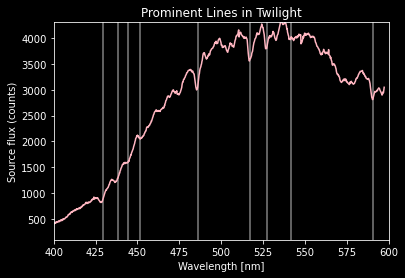

In [145]:
pl.plot(wavelengths, flats_line, color='lightpink')
pl.vlines(x=improved_flats_guess, ymin=0, ymax=max(flats_line), color='grey')
pl.xlim(400,600)
# pl.xlim(400,600)
pl.ylim(100,4300)
pl.title('Prominent Lines in Twilight')
pl.ylabel("Source flux (counts)")
pl.xlabel("Wavelength [nm]")

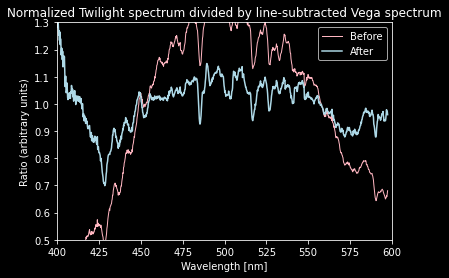

In [146]:
pl.title("Normalized Twilight spectrum divided by line-subtracted Vega spectrum")
pl.ylabel("Ratio (arbitrary units)")
pl.xlabel("Wavelength [nm]")
pl.xlim(400, 600)
pl.ylim(0.5, 1.3)
selection = wavelengths>400*u.nm
flats_linmod = linfitter(Linear1D(), wavelengths[selection], flats_line[selection])
flats_div_vega_linmod = linfitter(Linear1D(), wavelengths[selection], (flats_line / vega_spectrum_minus_lines)[selection])

pl.plot(wavelengths, flats_line / flats_linmod(wavelengths), label='Before', linewidth=1, color='lightpink');
pl.plot(wavelengths, flats_line / vega_spectrum_minus_lines / flats_div_vega_linmod(wavelengths), label='After', color='lightblue');
pl.legend(loc='best');

In [147]:
# moment analysis wavelength~430 nm
flats_fixed = (flats_line / vega_spectrum_minus_lines / flats_div_vega_linmod(wavelengths))
selection_430 = ((wavelengths > 426*u.nm) & (wavelengths < 431*u.nm))
nu_430 = wavelengths[1] - wavelengths[0]
m0 = (flats_fixed[selection_430] * nu_430).sum()
m1 = (wavelengths[selection_430] * flats_fixed[selection_430] * nu_430).sum() / m0
m2 = ((wavelengths[selection_430] - m1)**2 * flats_fixed[selection_430] * nu_430).sum() / m0
sigma = m2**0.5
vel = sigma / m1 * constants.c
print('Moments: ',m0,m1,m2,m2**0.5, vel)

# equivalent width
# eqw_hbeta = -flats_div_vega_linmod(wavelengths[selection]).amplitude * (2*np.pi)**0.5 * flats_linmod.stddev
# eqw_hbeta


Moments:  -3.657326573170731 nm 428.4907479258556 nm 2.04905269478763 nm2 1.4314512547717544 nm 1001511.2164089595 m / s


In [148]:
# moment analysis wavelength~438 nm
flats_fixed = (flats_line / vega_spectrum_minus_lines / flats_div_vega_linmod(wavelengths))
selection_438 = ((wavelengths > 433*u.nm) & (wavelengths < 441*u.nm))
nu_438 = wavelengths[1] - wavelengths[0]
m0 = (flats_fixed[selection_438] * nu_438).sum()
m1 = (wavelengths[selection_438] * flats_fixed[selection_438] * nu_438).sum() / m0
m2 = ((wavelengths[selection_438] - m1)**2 * flats_fixed[selection_438] * nu_438).sum() / m0
sigma = m2**0.5
vel = sigma / m1 * constants.c
print('Moments: ',m0,m1,m2,m2**0.5, vel)

# equivalent width
# eqw_hbeta = -flats_div_vega_linmod(wavelengths[selection]).amplitude * (2*np.pi)**0.5 * flats_linmod.stddev
# eqw_hbeta


Moments:  -7.138502669007128 nm 437.06406060941026 nm 5.497393638839676 nm2 2.344652135997934 nm 1608251.7194977915 m / s


In [149]:
# moment analysis wavelength~444 nm
selection_444 = ((wavelengths > 441.5*u.nm) & (wavelengths < 447.5*u.nm))
nu_444 = wavelengths[1] - wavelengths[0]
m0 = (flats_fixed[selection_444] * nu_444).sum()
m1 = (wavelengths[selection_444] * flats_fixed[selection_444] * nu_444).sum() / m0
m2 = ((wavelengths[selection_444] - m1)**2 * flats_fixed[selection_444] * nu_444).sum() / m0
sigma = m2**0.5
vel = sigma / m1 * constants.c
print('Moments: ',m0,m1,m2,m2**0.5, vel)

# equivalent width
# eqw_hbeta = -flats_div_vega_linmod(wavelengths[selection]).amplitude * (2*np.pi)**0.5 * flats_linmod.stddev
# eqw_hbeta


Moments:  -5.511583367949864 nm 444.47300653660886 nm 2.975633753352099 nm2 1.725002537201641 nm 1163496.4172820293 m / s


In [150]:
# moment analysis wavelength~451 nm
flats_fixed = (flats_line / vega_spectrum_minus_lines / flats_div_vega_linmod(wavelengths))
selection_451 = ((wavelengths > 449*u.nm) & (wavelengths < 455*u.nm))
nu_451 = wavelengths[1] - wavelengths[0]
m0 = (flats_fixed[selection_451] * nu_451).sum()
m1 = (wavelengths[selection_451] * flats_fixed[selection_451] * nu_451).sum() / m0
m2 = ((wavelengths[selection_451] - m1)**2 * flats_fixed[selection_451] * nu_451).sum() / m0
sigma = m2**0.5
vel = sigma / m1 * constants.c
print('Moments: ',m0,m1,m2,m2**0.5, vel)

# equivalent width
# eqw_hbeta = -flats_div_vega_linmod(wavelengths[selection]).amplitude * (2*np.pi)**0.5 * flats_linmod.stddev
# eqw_hbeta


Moments:  -5.828439174610758 nm 452.02642434175016 nm 2.983979075891793 nm2 1.7274197740826613 nm 1145657.4044850909 m / s


In [151]:
# moment analysis wavelength~486 nm
flats_fixed = (flats_line / vega_spectrum_minus_lines / flats_div_vega_linmod(wavelengths))
selection_486 = ((wavelengths > 483.5*u.nm) & (wavelengths < 487*u.nm))
nu_486 = wavelengths[1] - wavelengths[0]
m0 = (flats_fixed[selection_486] * nu_486).sum()
m1 = (wavelengths[selection_486] * flats_fixed[selection_486] * nu_486).sum() / m0
m2 = ((wavelengths[selection_486] - m1)**2 * flats_fixed[selection_486] * nu_486).sum() / m0
sigma = m2**0.5
vel = sigma / m1 * constants.c
print('Moments: ',m0,m1,m2,m2**0.5, vel)

# equivalent width
# eqw_hbeta = -flats_div_vega_linmod(wavelengths[selection]).amplitude * (2*np.pi)**0.5 * flats_linmod.stddev
# eqw_hbeta


Moments:  -3.365372943468987 nm 485.22945663129286 nm 0.9891574236961502 nm2 0.9945639364546405 nm 614477.8786059043 m / s


In [152]:
# moment analysis wavelength~516 nm
flats_fixed = (flats_line / vega_spectrum_minus_lines / flats_div_vega_linmod(wavelengths))
selection_516 = ((wavelengths > 515*u.nm) & (wavelengths < 520*u.nm))
nu_516 = wavelengths[1] - wavelengths[0]
m0 = (flats_fixed[selection_516] * nu_516).sum()
m1 = (wavelengths[selection_516] * flats_fixed[selection_516] * nu_516).sum() / m0
m2 = ((wavelengths[selection_516] - m1)**2 * flats_fixed[selection_516] * nu_516).sum() / m0
sigma = m2**0.5
vel = sigma / m1 * constants.c
print('Moments: ',m0,m1,m2,m2**0.5, vel)

# equivalent width
# eqw_hbeta = -flats_div_vega_linmod(wavelengths[selection]).amplitude * (2*np.pi)**0.5 * flats_linmod.stddev
# eqw_hbeta


Moments:  -4.83868310085136 nm 517.5059046285438 nm 2.0243096367202726 nm2 1.4227823574673228 nm 824221.3592718821 m / s


In [153]:
# moment analysis wavelength~527 nm
flats_fixed = (flats_line / vega_spectrum_minus_lines / flats_div_vega_linmod(wavelengths))
selection_527 = ((wavelengths > 524*u.nm) & (wavelengths < 529*u.nm))
nu_527 = wavelengths[1] - wavelengths[0]
m0 = (flats_fixed[selection_527] * nu_527).sum()
m1 = (wavelengths[selection_527] * flats_fixed[selection_527] * nu_527).sum() / m0
m2 = ((wavelengths[selection_527] - m1)**2 * flats_fixed[selection_527] * nu_527).sum() / m0
sigma = m2**0.5
vel = sigma / m1 * constants.c
print('Moments: ',m0,m1,m2,m2**0.5, vel)

# equivalent width
# eqw_hbeta = -flats_div_vega_linmod(wavelengths[selection]).amplitude * (2*np.pi)**0.5 * flats_linmod.stddev
# eqw_hbeta


Moments:  -5.246470473985735 nm 526.4520462568231 nm 2.1991203838623625 nm2 1.4829431492347784 nm 844474.2022457151 m / s


In [154]:
# moment analysis wavelength~541 nm
flats_fixed = (flats_line / vega_spectrum_minus_lines / flats_div_vega_linmod(wavelengths))
selection_541 = ((wavelengths > 539*u.nm) & (wavelengths < 542*u.nm))
nu_541 = wavelengths[1] - wavelengths[0]
m0 = (flats_fixed[selection_541] * nu_541).sum()
m1 = (wavelengths[selection_541] * flats_fixed[selection_541] * nu_541).sum() / m0
m2 = ((wavelengths[selection_541] - m1)**2 * flats_fixed[selection_541] * nu_541).sum() / m0
sigma = m2**0.5
vel = sigma / m1 * constants.c
print('Moments: ',m0,m1,m2,m2**0.5, vel)

# equivalent width
# eqw_hbeta = -flats_div_vega_linmod(wavelengths[selection]).amplitude * (2*np.pi)**0.5 * flats_linmod.stddev
# eqw_hbeta


Moments:  -3.029578685502708 nm 540.4303215392712 nm 0.735935924103642 nm2 0.8578670783423513 nm 475883.8832747536 m / s


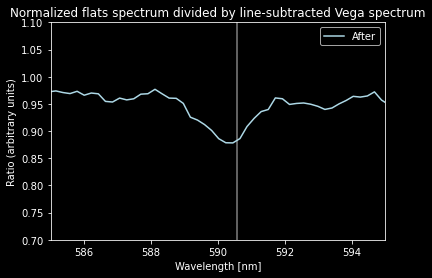

In [155]:
pl.title("Normalized flats spectrum divided by line-subtracted Vega spectrum")
pl.ylabel("Ratio (arbitrary units)")
pl.xlabel("Wavelength [nm]")
pl.xlim(585, 595)
pl.ylim(0.7, 1.1)
selection = wavelengths>400*u.nm
flats_linmod = linfitter(Linear1D(), wavelengths[selection], flats_line[selection])
flats_div_vega_linmod = linfitter(Linear1D(), wavelengths[selection], (flats_line / vega_spectrum_minus_lines)[selection])

pl.vlines(x=improved_flats_guess, ymin=0, ymax=max(flats_line), color='grey')
pl.plot(wavelengths, flats_line / vega_spectrum_minus_lines / flats_div_vega_linmod(wavelengths), label='After', color='lightblue');
pl.legend(loc='best');

In [156]:
improved_flats_guess

[429.45069065344774,
 438.41055130429487,
 444.5011232151871,
 451.59050298509885,
 486.3334667628862,
 516.975342750917,
 527.2668630496142,
 541.7335135678866,
 590.5627132615375]

In [157]:
# moment analysis wavelength~590 nm
flats_fixed = (flats_line / vega_spectrum_minus_lines / flats_div_vega_linmod(wavelengths))
selection_590 = ((wavelengths > 588*u.nm) & (wavelengths < 592*u.nm))
nu_590 = wavelengths[1] - wavelengths[0]
m0 = (flats_fixed[selection_590] * nu_590).sum()
m1 = (wavelengths[selection_590] * flats_fixed[selection_590] * nu_590).sum() / m0
m2 = ((wavelengths[selection_590] - m1)**2 * flats_fixed[selection_590] * nu_590).sum() / m0
sigma = m2**0.5
vel = sigma / m1 * constants.c
print('Moments: ',m0,m1,m2,m2**0.5, vel)

# equivalent width
# eqw_hbeta = -flats_div_vega_linmod(wavelengths[selection]).amplitude * (2*np.pi)**0.5 * flats_linmod.stddev
# eqw_hbeta


Moments:  -3.728537083692585 nm 590.0109690069415 nm 1.3770495657695647 nm2 1.1734775523074843 nm 596259.6261662813 m / s


## Ring Nebula

Text(0.5, 0, 'Wavelength [nm]')

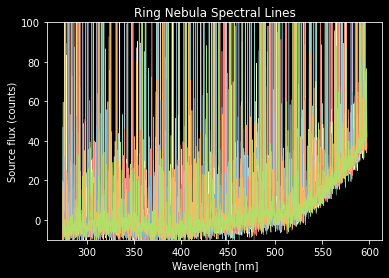

In [158]:
for index in ring_spectra:
    pl.plot(wavelengths, ring_spectra[index], linewidth=0.5)
# pl.xlim(0,800)
pl.ylim(-10,100)
pl.title("Ring Nebula Spectral Lines")
pl.ylabel("Source flux (counts)")
pl.xlabel("Wavelength [nm]")

(0.0, 100.0)

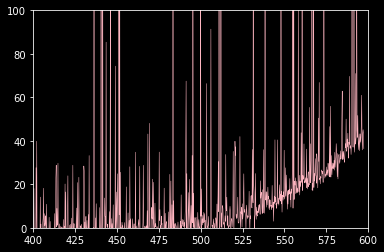

In [159]:
ring_line = ring_spectra[3]
wavelengths = linfit_wlmodel_he(xaxis) * u.nm
pl.plot(wavelengths, ring_line, color='lightpink', linewidth=0.5)
pl.xlim(400,600)
pl.ylim(-0,100)

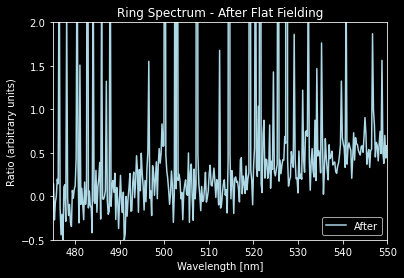

In [160]:
pl.title("Ring Spectrum - After Flat Fielding")
pl.ylabel("Ratio (arbitrary units)")
pl.xlabel("Wavelength [nm]")
pl.xlim(475, 550)
pl.ylim(-0.5, 2)
selection = wavelengths>400*u.nm
ring_linmod = linfitter(Linear1D(), wavelengths[selection], ring_spectra[4][selection])
ring_div_vega_linmod = linfitter(Linear1D(), wavelengths[selection], (ring_spectra[4] / vega_spectrum_minus_lines)[selection])
# pl.plot(wavelengths, ring_spectra[4] / ring_linmod(wavelengths), label='Before', linewidth=1, color='lightpink');
pl.plot(wavelengths, ring_spectra[4] / vega_spectrum_minus_lines / ring_div_vega_linmod(wavelengths), label='After', color='lightblue');
pl.legend(loc='best');

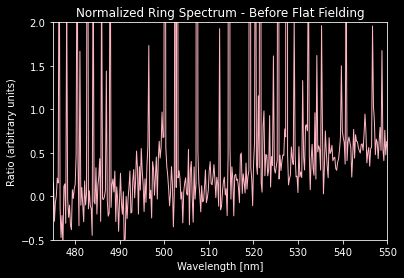

In [161]:
pl.title("Normalized Ring Spectrum - Before Flat Fielding")
pl.ylabel("Ratio (arbitrary units)")
pl.xlabel("Wavelength [nm]")
pl.xlim(475, 550)
pl.ylim(-0.5, 2)
pl.plot(wavelengths, ring_spectra[4] / ring_linmod(wavelengths), label='Before', linewidth=1, color='lightpink');

In [162]:
ring_guess = [292, 511, 567]
npixels = 2
improved_ring_guess = [np.average(xaxis[g-npixels:g+npixels],
                                    weights=ring_line[g-npixels:g+npixels] - np.median(ring_line))
                         for g in ring_guess]
improved_ring_guess

[291.3287210001782, 510.94204283188475, 566.5391287548657]

Text(0.5, 0, 'wavelength')

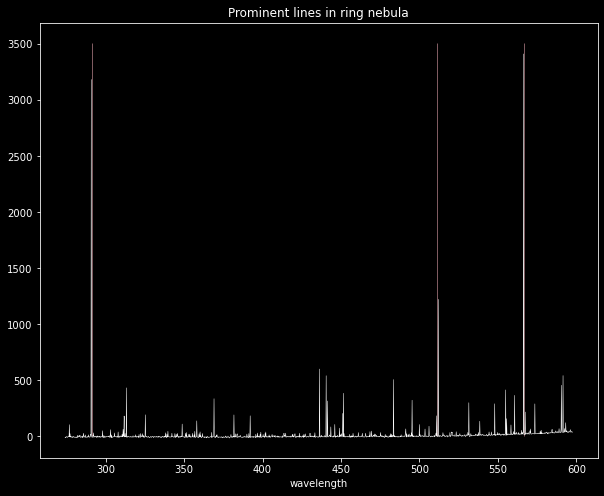

In [163]:
pl.figure(figsize=(10,8))
pl.plot(wavelengths, ring_line, color='white', linewidth=0.5)
pl.vlines(x=improved_ring_guess, ymin=0, ymax=max(ring_line)+100, color='lightpink', linewidth=0.5)
# pl.xlim(150,800)
# pl.ylim(50,350)
pl.title('Prominent lines in ring nebula')
pl.xlabel('wavelength')

## 31 Cygni Binary System

Text(0.5, 0, 'Wavelength [nm]')

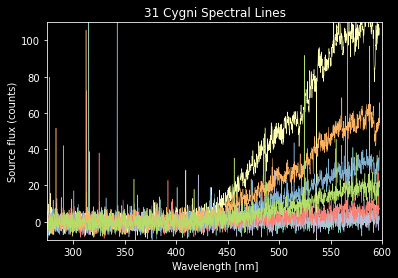

In [164]:
for index in cyg31_spectra:
    pl.plot(wavelengths, cyg31_spectra[index], linewidth=0.5)
pl.xlim(275,600)
pl.ylim(-10,110)
pl.title("31 Cygni Spectral Lines")
pl.ylabel("Source flux (counts)")
pl.xlabel("Wavelength [nm]")

Text(0.5, 0, 'Wavelength [nm]')

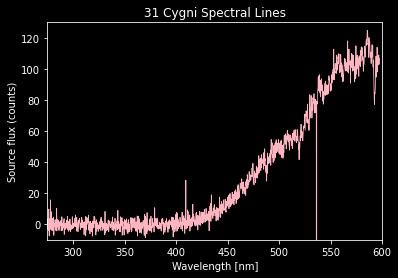

In [165]:
cyg31_line = cyg31_spectra[1]
wavelengths = linfit_wlmodel_he(xaxis) * u.nm
pl.plot(wavelengths, cyg31_line, color='lightpink', linewidth=0.8)
pl.xlim(275,600)
pl.ylim(-10,130)
pl.title("31 Cygni Spectral Lines")
pl.ylabel("Source flux (counts)")
pl.xlabel("Wavelength [nm]")

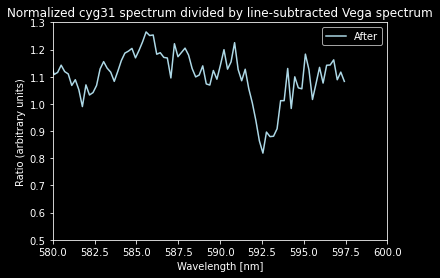

In [166]:
pl.title("Normalized cyg31 spectrum divided by line-subtracted Vega spectrum")
pl.ylabel("Ratio (arbitrary units)")
pl.xlabel("Wavelength [nm]")
pl.xlim(580, 600)
pl.ylim(0.5, 1.3)
selection = wavelengths>400*u.nm
cyg31_linmod = linfitter(Linear1D(), wavelengths[selection], cyg31_line[selection])
cyg31_div_vega_linmod = linfitter(Linear1D(), wavelengths[selection], (cyg31_line / vega_spectrum_minus_lines)[selection])
# pl.plot(wavelengths, cyg31_line / cyg31_linmod(wavelengths), label='Before', linewidth=1, color='lightpink');
pl.plot(wavelengths, cyg31_line / vega_spectrum_minus_lines / cyg31_div_vega_linmod(wavelengths), label='After', color='lightblue');
pl.legend(loc='best');

In [167]:
# for index in jupiter_spectra:
#     pl.plot(wavelengths, jupiter_spectra[index], linewidth=0.5)
# pl.xlim(400,600)
# pl.ylim(300,3500)
# pl.title("Jupiter Spectral Lines")
# pl.ylabel("Source flux (counts)")
# pl.xlabel("Wavelength [nm]")

# jupiter_line = jupiter_spectra[4]
# wavelengths = linfit_wlmodel_he(xaxis) * u.nm
# pl.plot(wavelengths, jupiter_line, color='lightpink', linewidth=0.8)
# pl.xlim(425,600)
# # pl.ylim(-0,1500)

# jupiter_guess = [430, 487, 520, 528, 546, 562, 573, 592]
# npixels = 10
# improved_jupiter_guess = [np.average(xaxis[g-npixels:g+npixels],
#                                     weights=jupiter_line[g-npixels:g+npixels] - np.median(jupiter_line))
#                          for g in jupiter_guess]
# improved_jupiter_guess

# pl.plot(wavelengths, jupiter_line, color='lightpink')
# pl.vlines(x=improved_jupiter_guess, ymin=0, ymax=max(jupiter_line), color='grey')
# pl.xlim(400,600)
# # pl.xlim(400,600)
# pl.ylim(100,3300)
# pl.title('Prominent Lines in Jupiter')
# pl.ylabel("Source flux (counts)")
# pl.xlabel("Wavelength [nm]")

# pl.title("Normalized Jupiter spectrum divided by line-subtracted Vega spectrum")
# pl.ylabel("Ratio (arbitrary units)")
# pl.xlabel("Wavelength [nm]")
# pl.xlim(400, 600)
# pl.ylim(0.5, 1.3)
# selection = wavelengths>400*u.nm
# jupiter_linmod = linfitter(Linear1D(), wavelengths[selection], jupiter_line[selection])
# jupiter_div_vega_linmod = linfitter(Linear1D(), wavelengths[selection], (jupiter_line / vega_spectrum_minus_lines)[selection])
# pl.plot(wavelengths, jupiter_line / jupiter_linmod(wavelengths), label='Before', linewidth=1, color='lightpink');
# pl.plot(wavelengths, jupiter_line / vega_spectrum_minus_lines / jupiter_div_vega_linmod(wavelengths), label='After', color='lightblue');
# pl.legend(loc='best');

# # moment analysis wavelength~430 nm
# selection_430 = ((wavelengths > 428*u.nm) & (wavelengths < 432*u.nm))
# nu_430 = wavelengths[1] - wavelengths[0]
# m0 = (jupiter_fixed[selection_430] * nu_430).sum()
# m1 = (wavelengths[selection_430] * jupiter_fixed[selection_430] * nu_430).sum() / m0
# m2 = ((wavelengths[selection_430] - m1)**2 * jupiter_fixed[selection_430] * nu_430).sum() / m0
# sigma = m2**0.5
# vel = sigma / m1 * constants.c
# print('Moments: ',m0,m1,m2,m2**0.5, vel)

# # equivalent width
# # eqw_hbeta = -jupiter_div_vega_linmod(wavelengths[selection]).amplitude * (2*np.pi)**0.5 * jupiter_linmod.stddev
# # eqw_hbeta

# jupiter_fixed = (jupiter_line / vega_spectrum_minus_lines / jupiter_div_vega_linmod(wavelengths))
# pl.plot(wavelengths, jupiter_fixed, color='lightpink');
# pl.title('jupiter Lines - Normalized & Divided by Line Subtracted Spectrum')
# pl.ylabel("Ratio (arbitrary units)")
# pl.xlabel("Wavelength [nm]")
# pl.ylim(0.8, 1.2)
# pl.xlim(400,600)